In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [3]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False, save_record = True):
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    
    print(f"Data shape: {proc_data.shape}")

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, proc_err, num_iteration = iteration, use_epochs = True)

    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)

    labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
    
    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        means = np.mean(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        density_map[int(list(i)[0]), int(list(i)[1])] = len(properties)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = means[1]
        z_std[int(list(i)[0]), int(list(i)[1])] = stds[1]

    print([dim, sigma, rate])
    print(np.sum(density_map))
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Average redshift std: {np.nanmean(z_std / (1 + z_map))}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (30, 20))
    plt.title(f"mean std: {round(np.nanmean(z_std / (1 + z_map)), 3)}")
    
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    plt.subplots_adjust(hspace = 0.07, wspace = 0)
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/5th_exploration/diagram/{data_type}_{len(proc_data[0])}_{dim}_{sigma}_{rate}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()

    if save_record:
    
        map_record = {}
        map_record["dim"] = dim
        map_record["sigma"] = sigma
        map_record["rate"] = rate
        map_record["band_cut"] = len(proc_data[0])
        map_record["mag_cut"] = len(proc_data)
        map_record["preproc"] = preproc
        map_record["som"] = som
        map_record["topo_err"] = som.topographic_error(proc_data)
        map_record["quan_err"] = som.quantization_error(proc_data)
        map_record["type"] = data_type
        map_record["distance"] = distance
        map_record["iter"] = iteration
        map_record["b_scale"] = b_scale
        map_record["prop_map"] = labels_map
        map_record["mean_std"] = (np.nanquantile(z_std / (1 + z_map), 0.25), np.nanquantile(z_std / (1 + z_map), 0.5), np.nanquantile(z_std / (1 + z_map), 0.75))
        map_record["z_scatter"] = z_std / (1 + z_map)
        
        try:
            with open(f"D:/SPHEREx_SOM/record/5th_exploration/SOM/{data_type}_{dim}_{sigma}_{rate}_{b_scale}_{iteration}.pkl",'wb') as handle:
                pickle.dump(map_record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    
    return som

In [4]:
data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
err = np.tile(data_all[0, 1::2],  (data.shape[0], 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\2134533818.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]


Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.09089377758312839
Quantization error: 5.014001160732791
Average redshift std: 0.1281899081668932


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


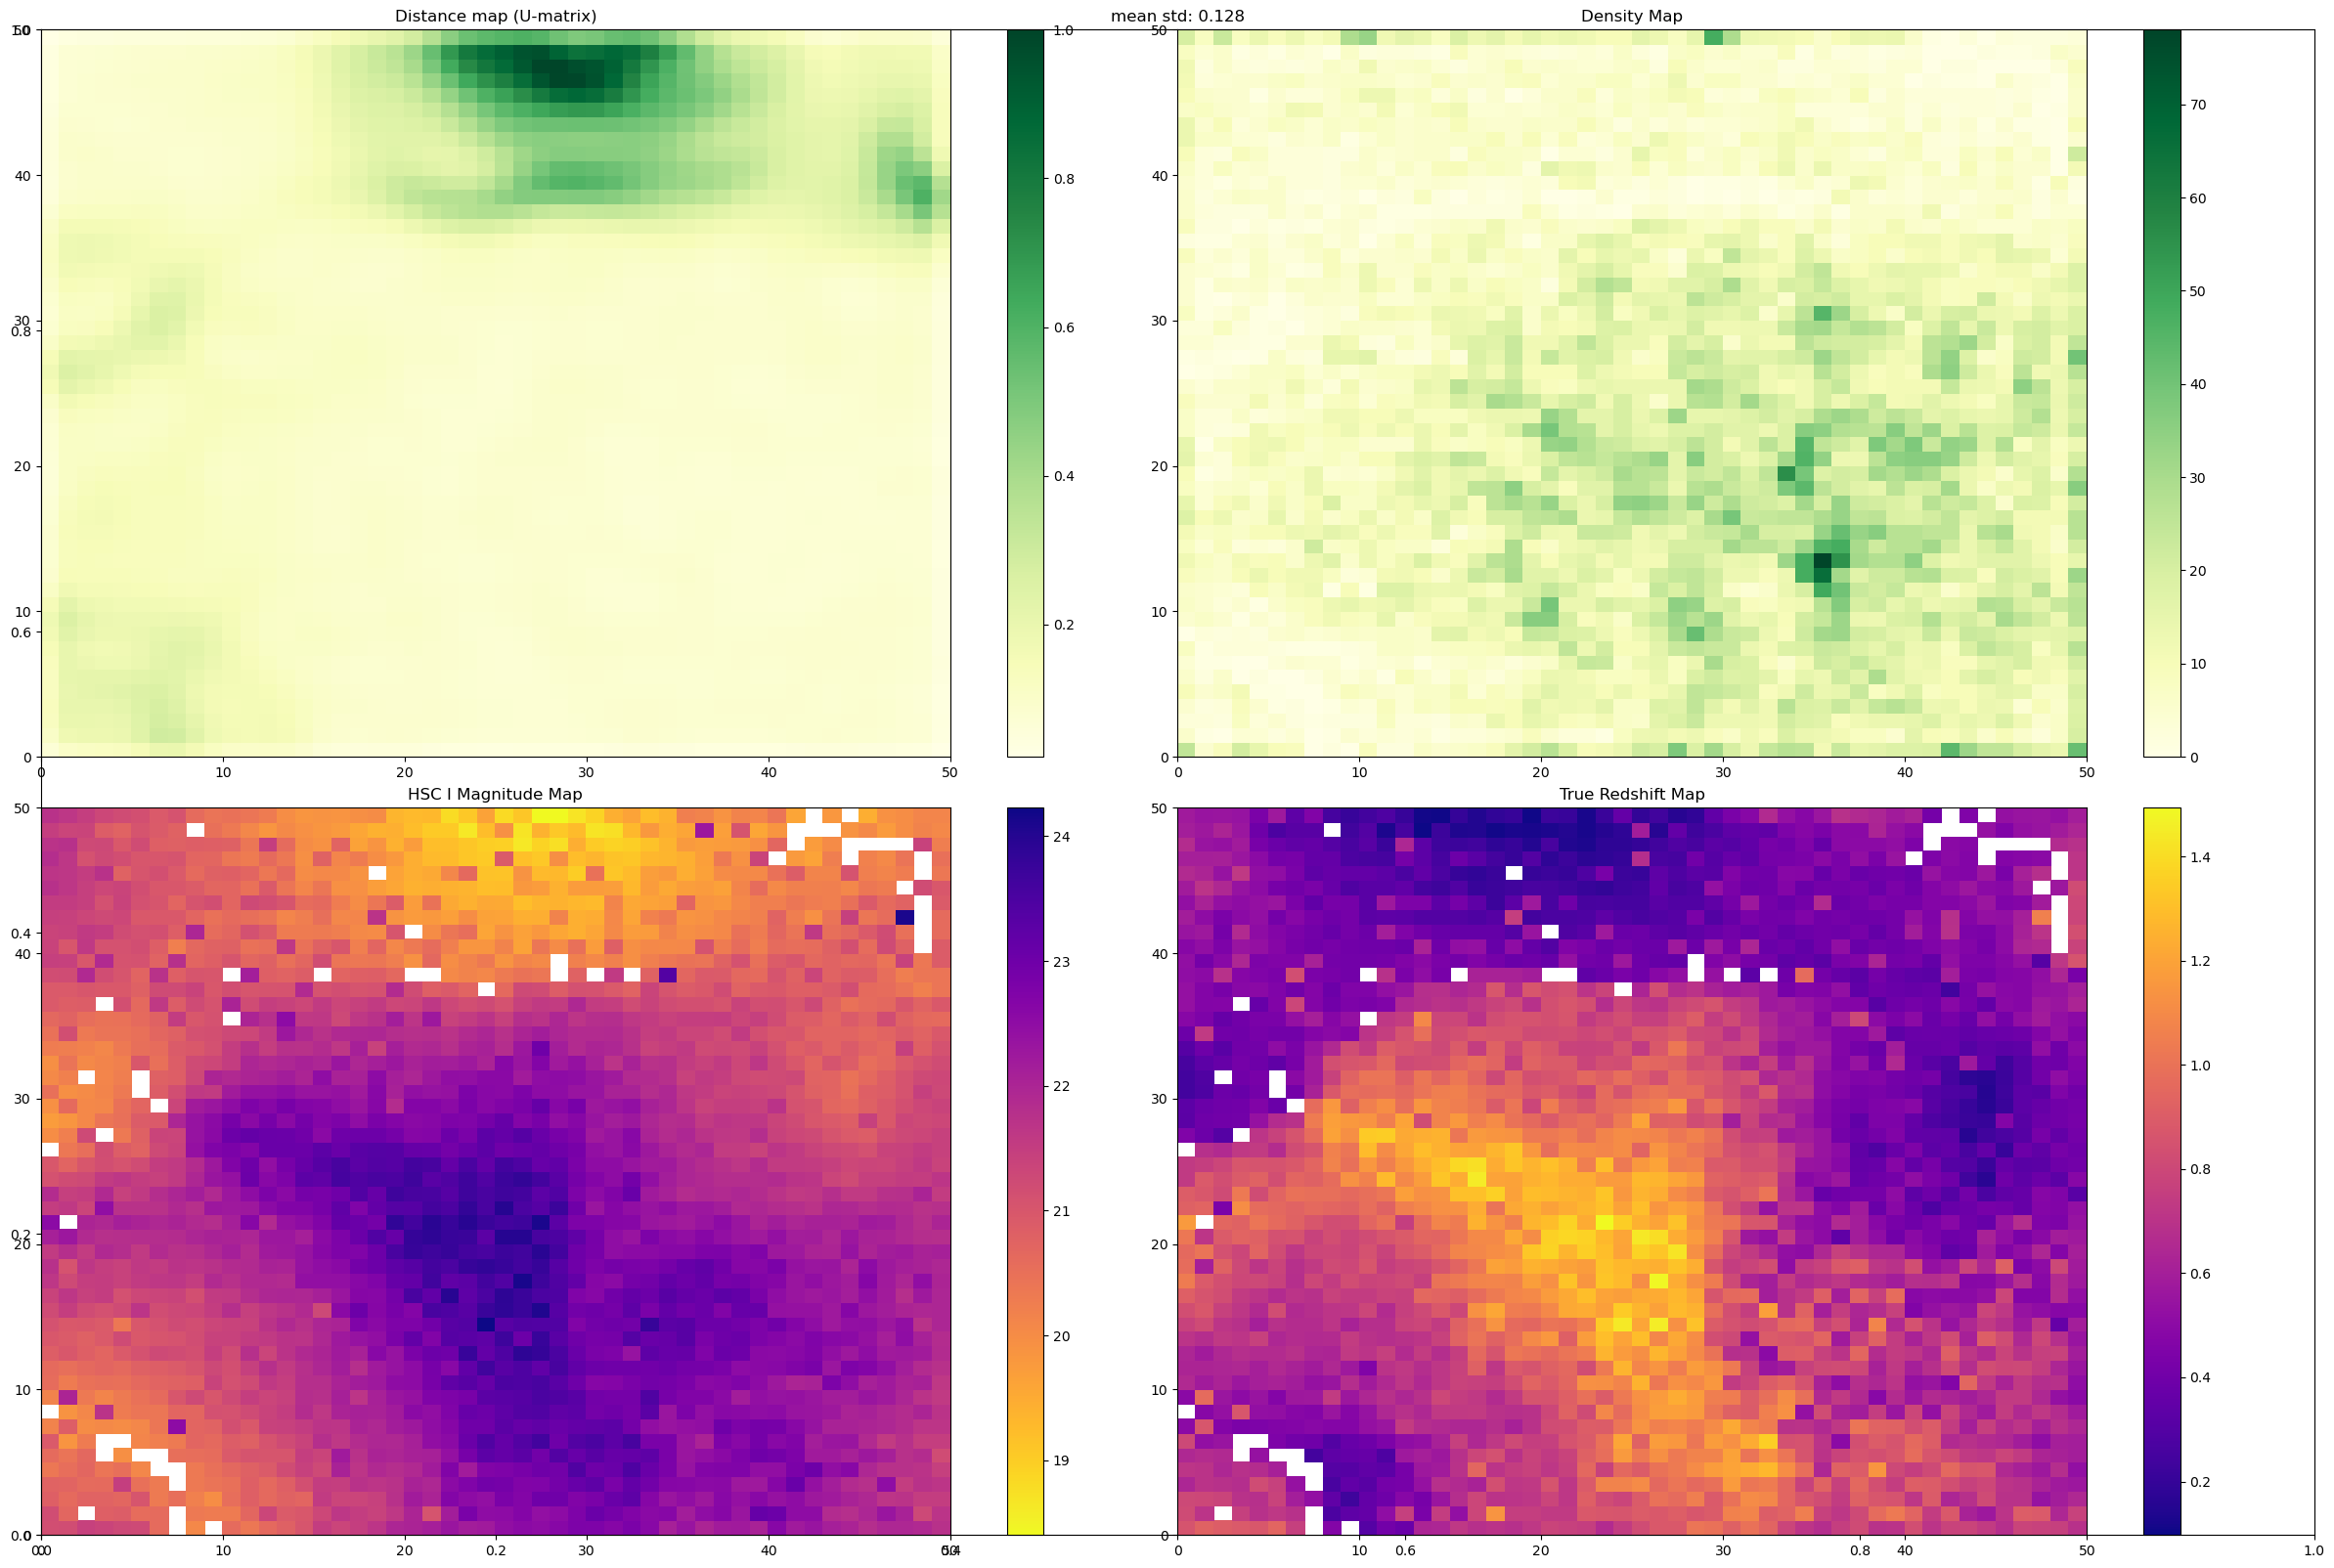

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.23673483138496781
Quantization error: 4.928818010793222
Average redshift std: 0.11506312542196334


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


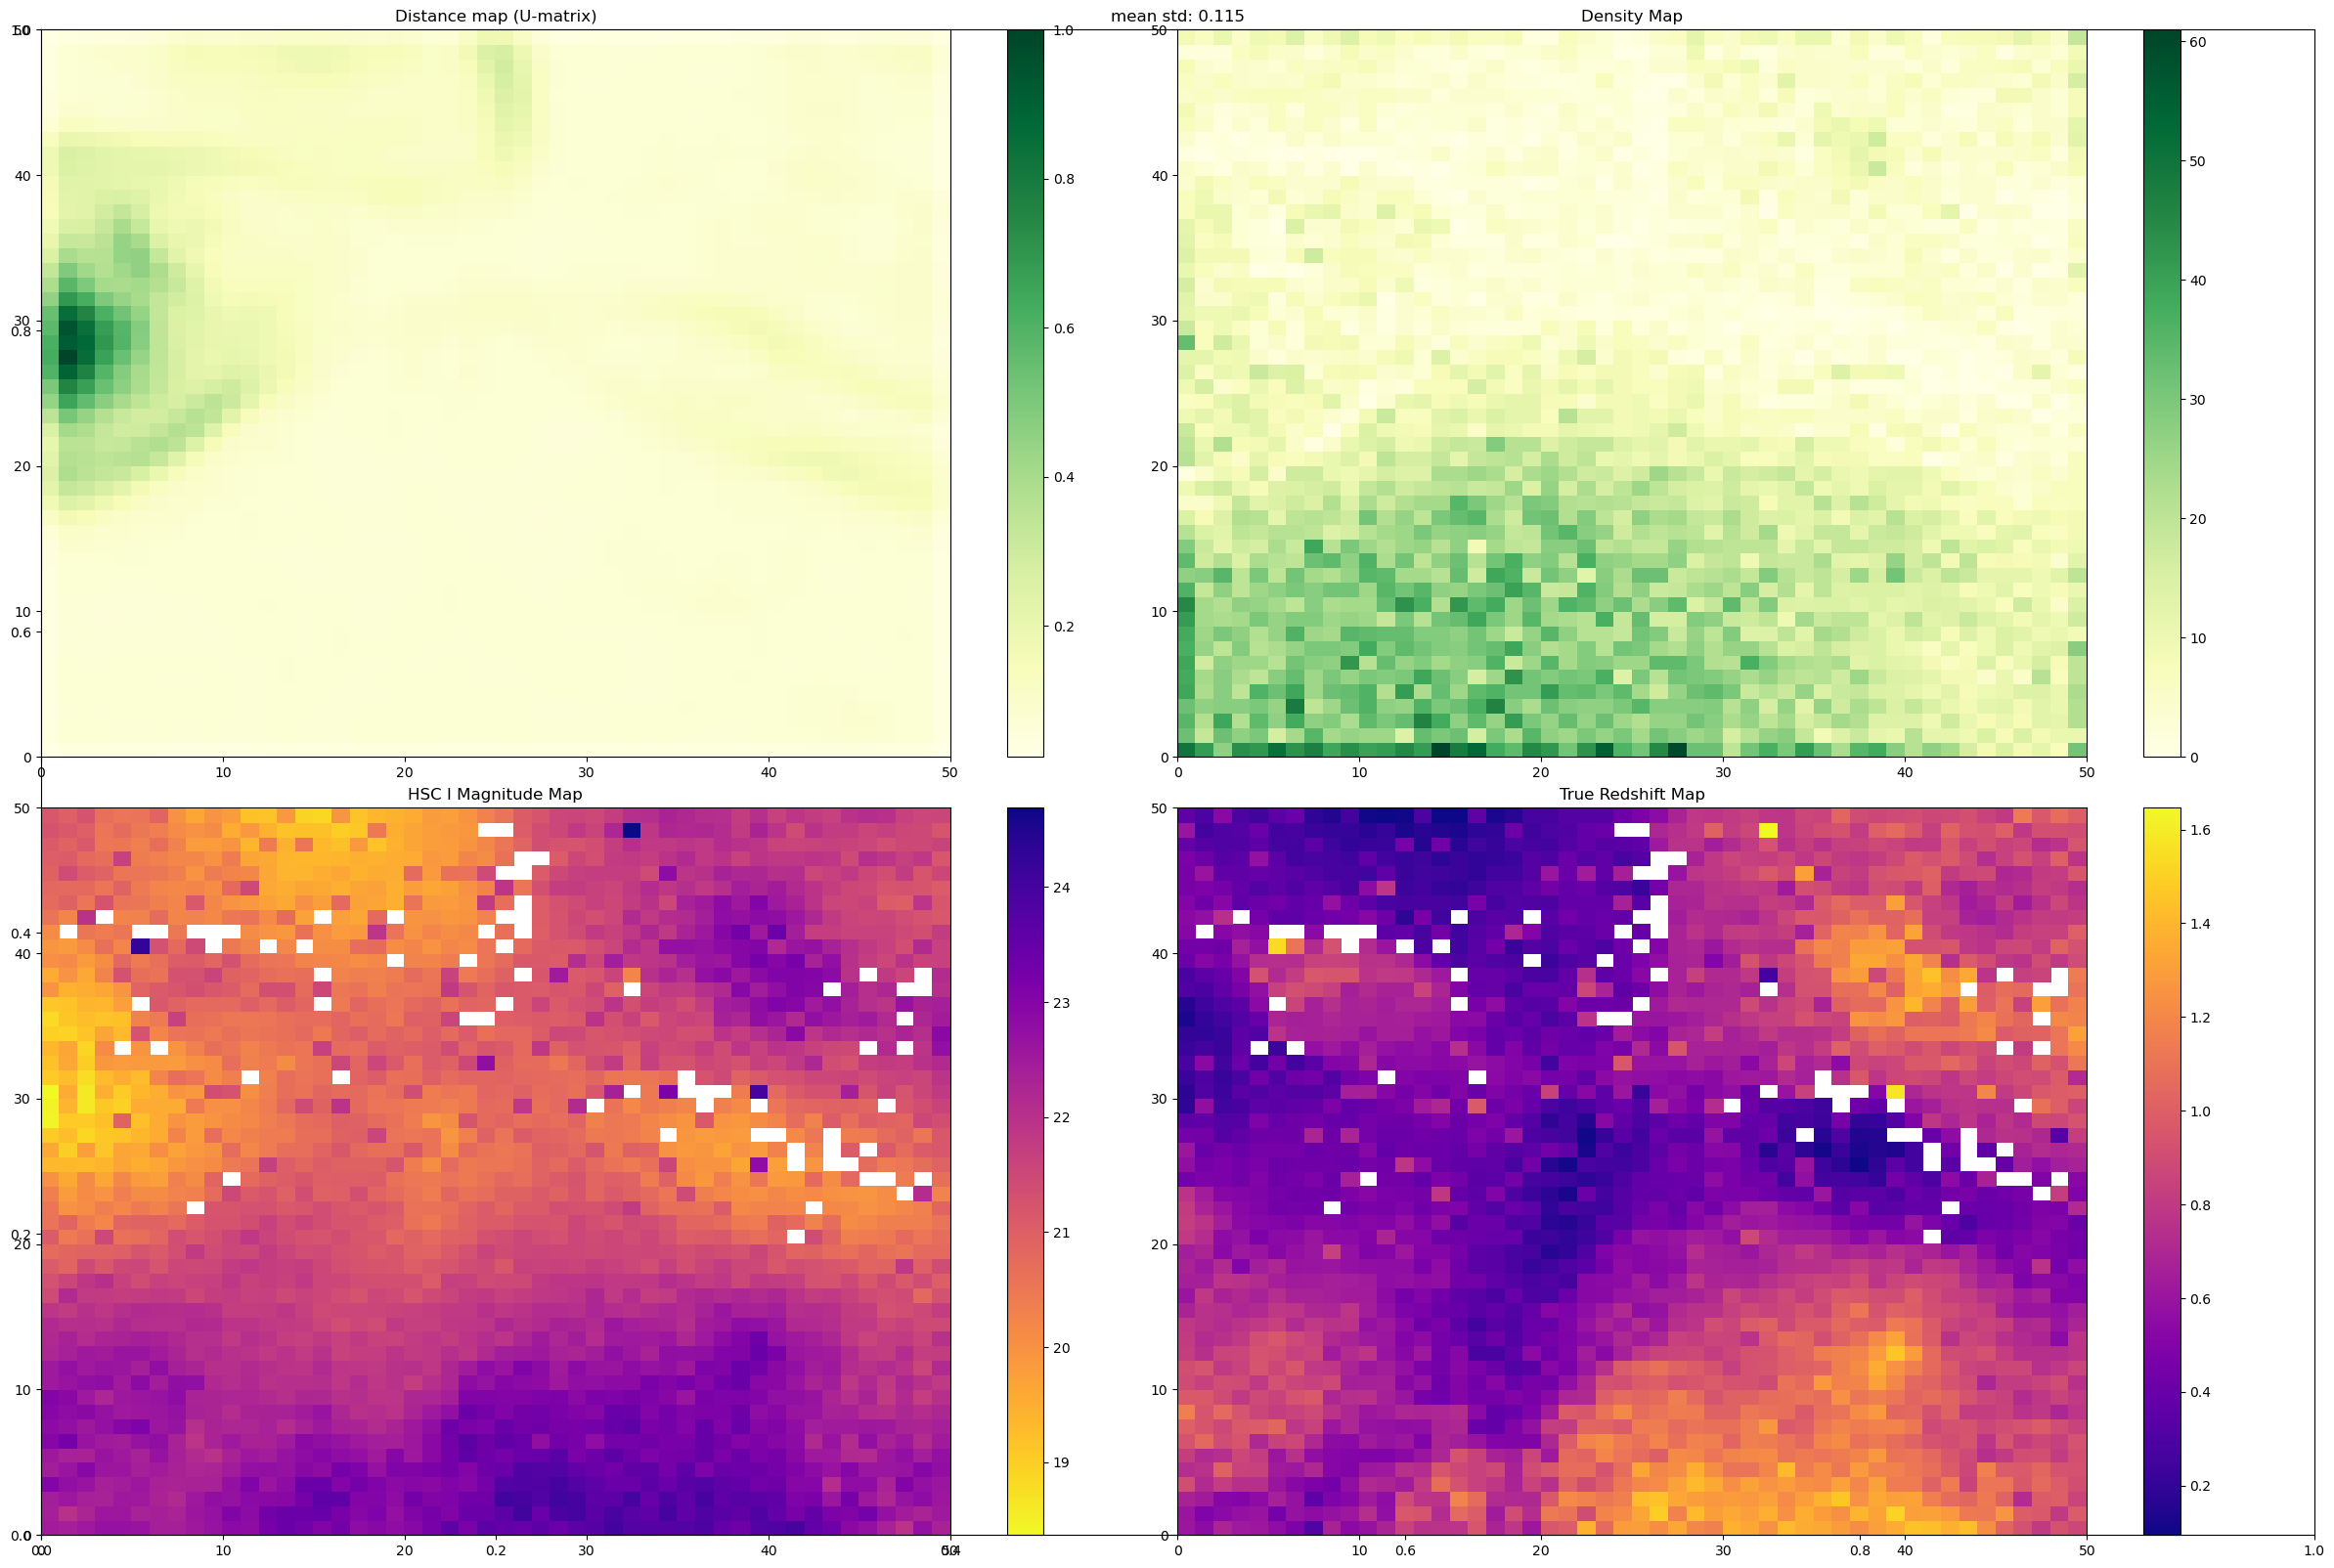

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.3007782232254152
Quantization error: 4.885630646618784
Average redshift std: 0.11590671056305996


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


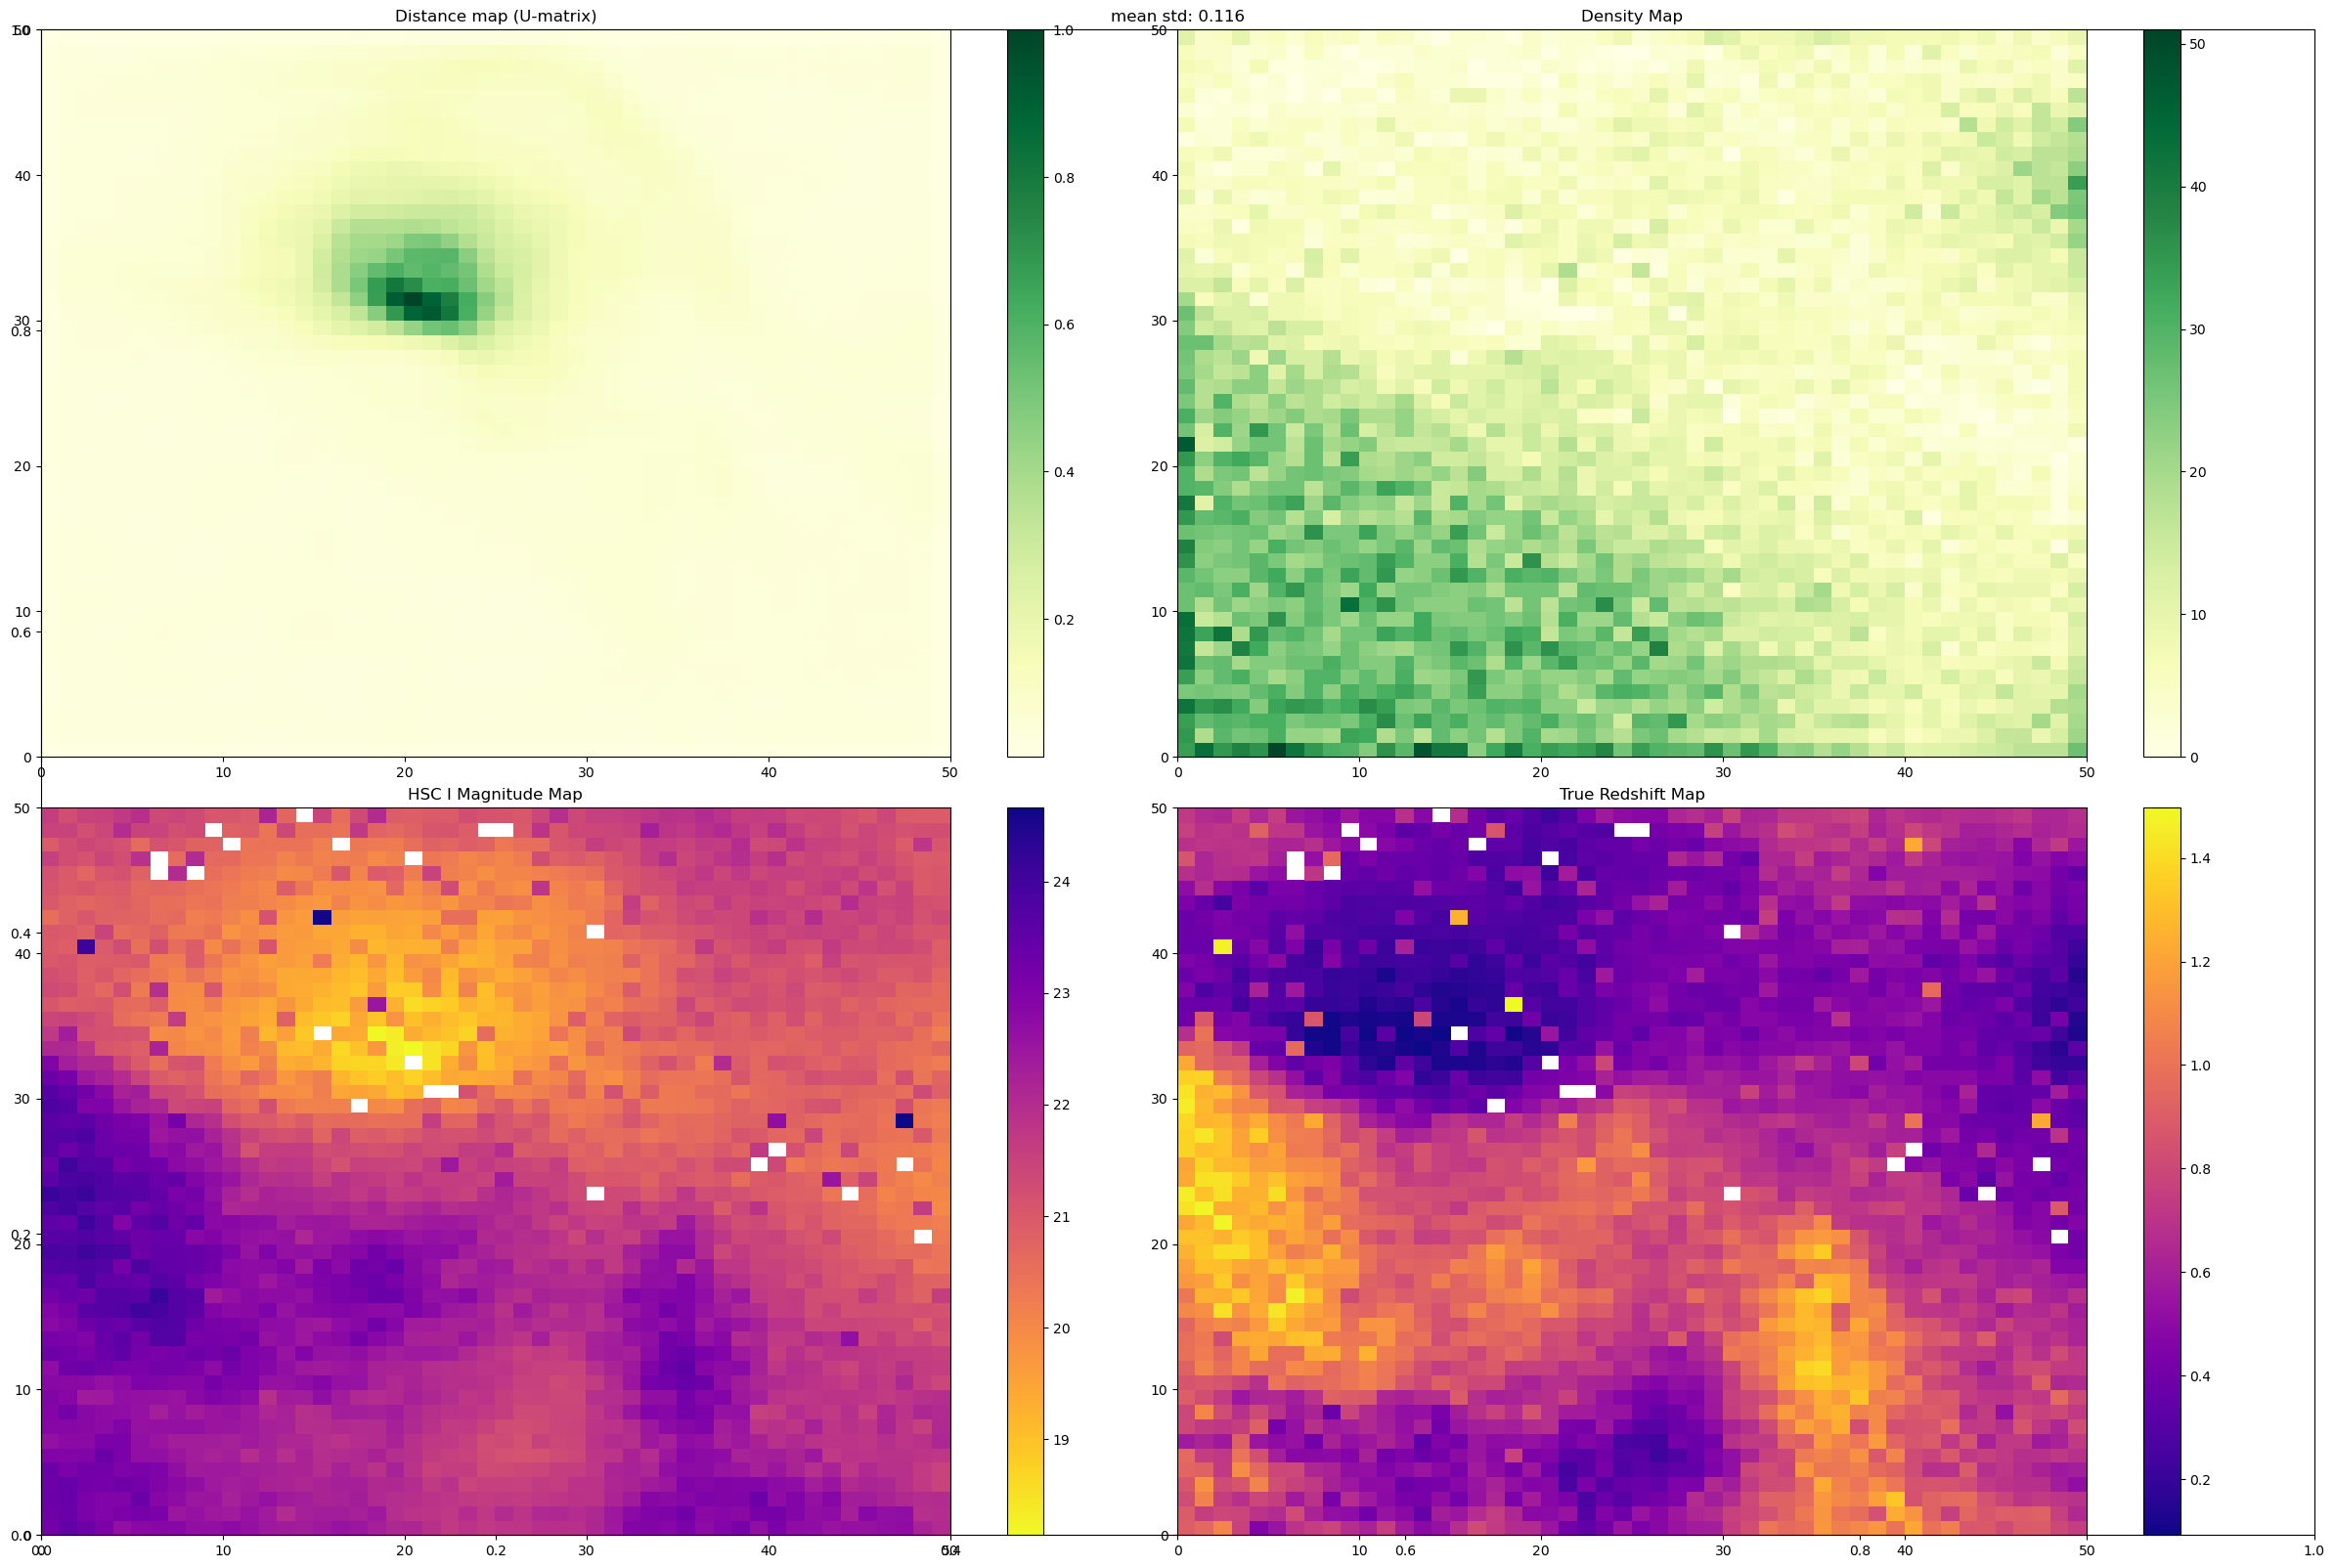

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.31843142539500724
Quantization error: 4.866373080933784
Average redshift std: 0.11605485536374567


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


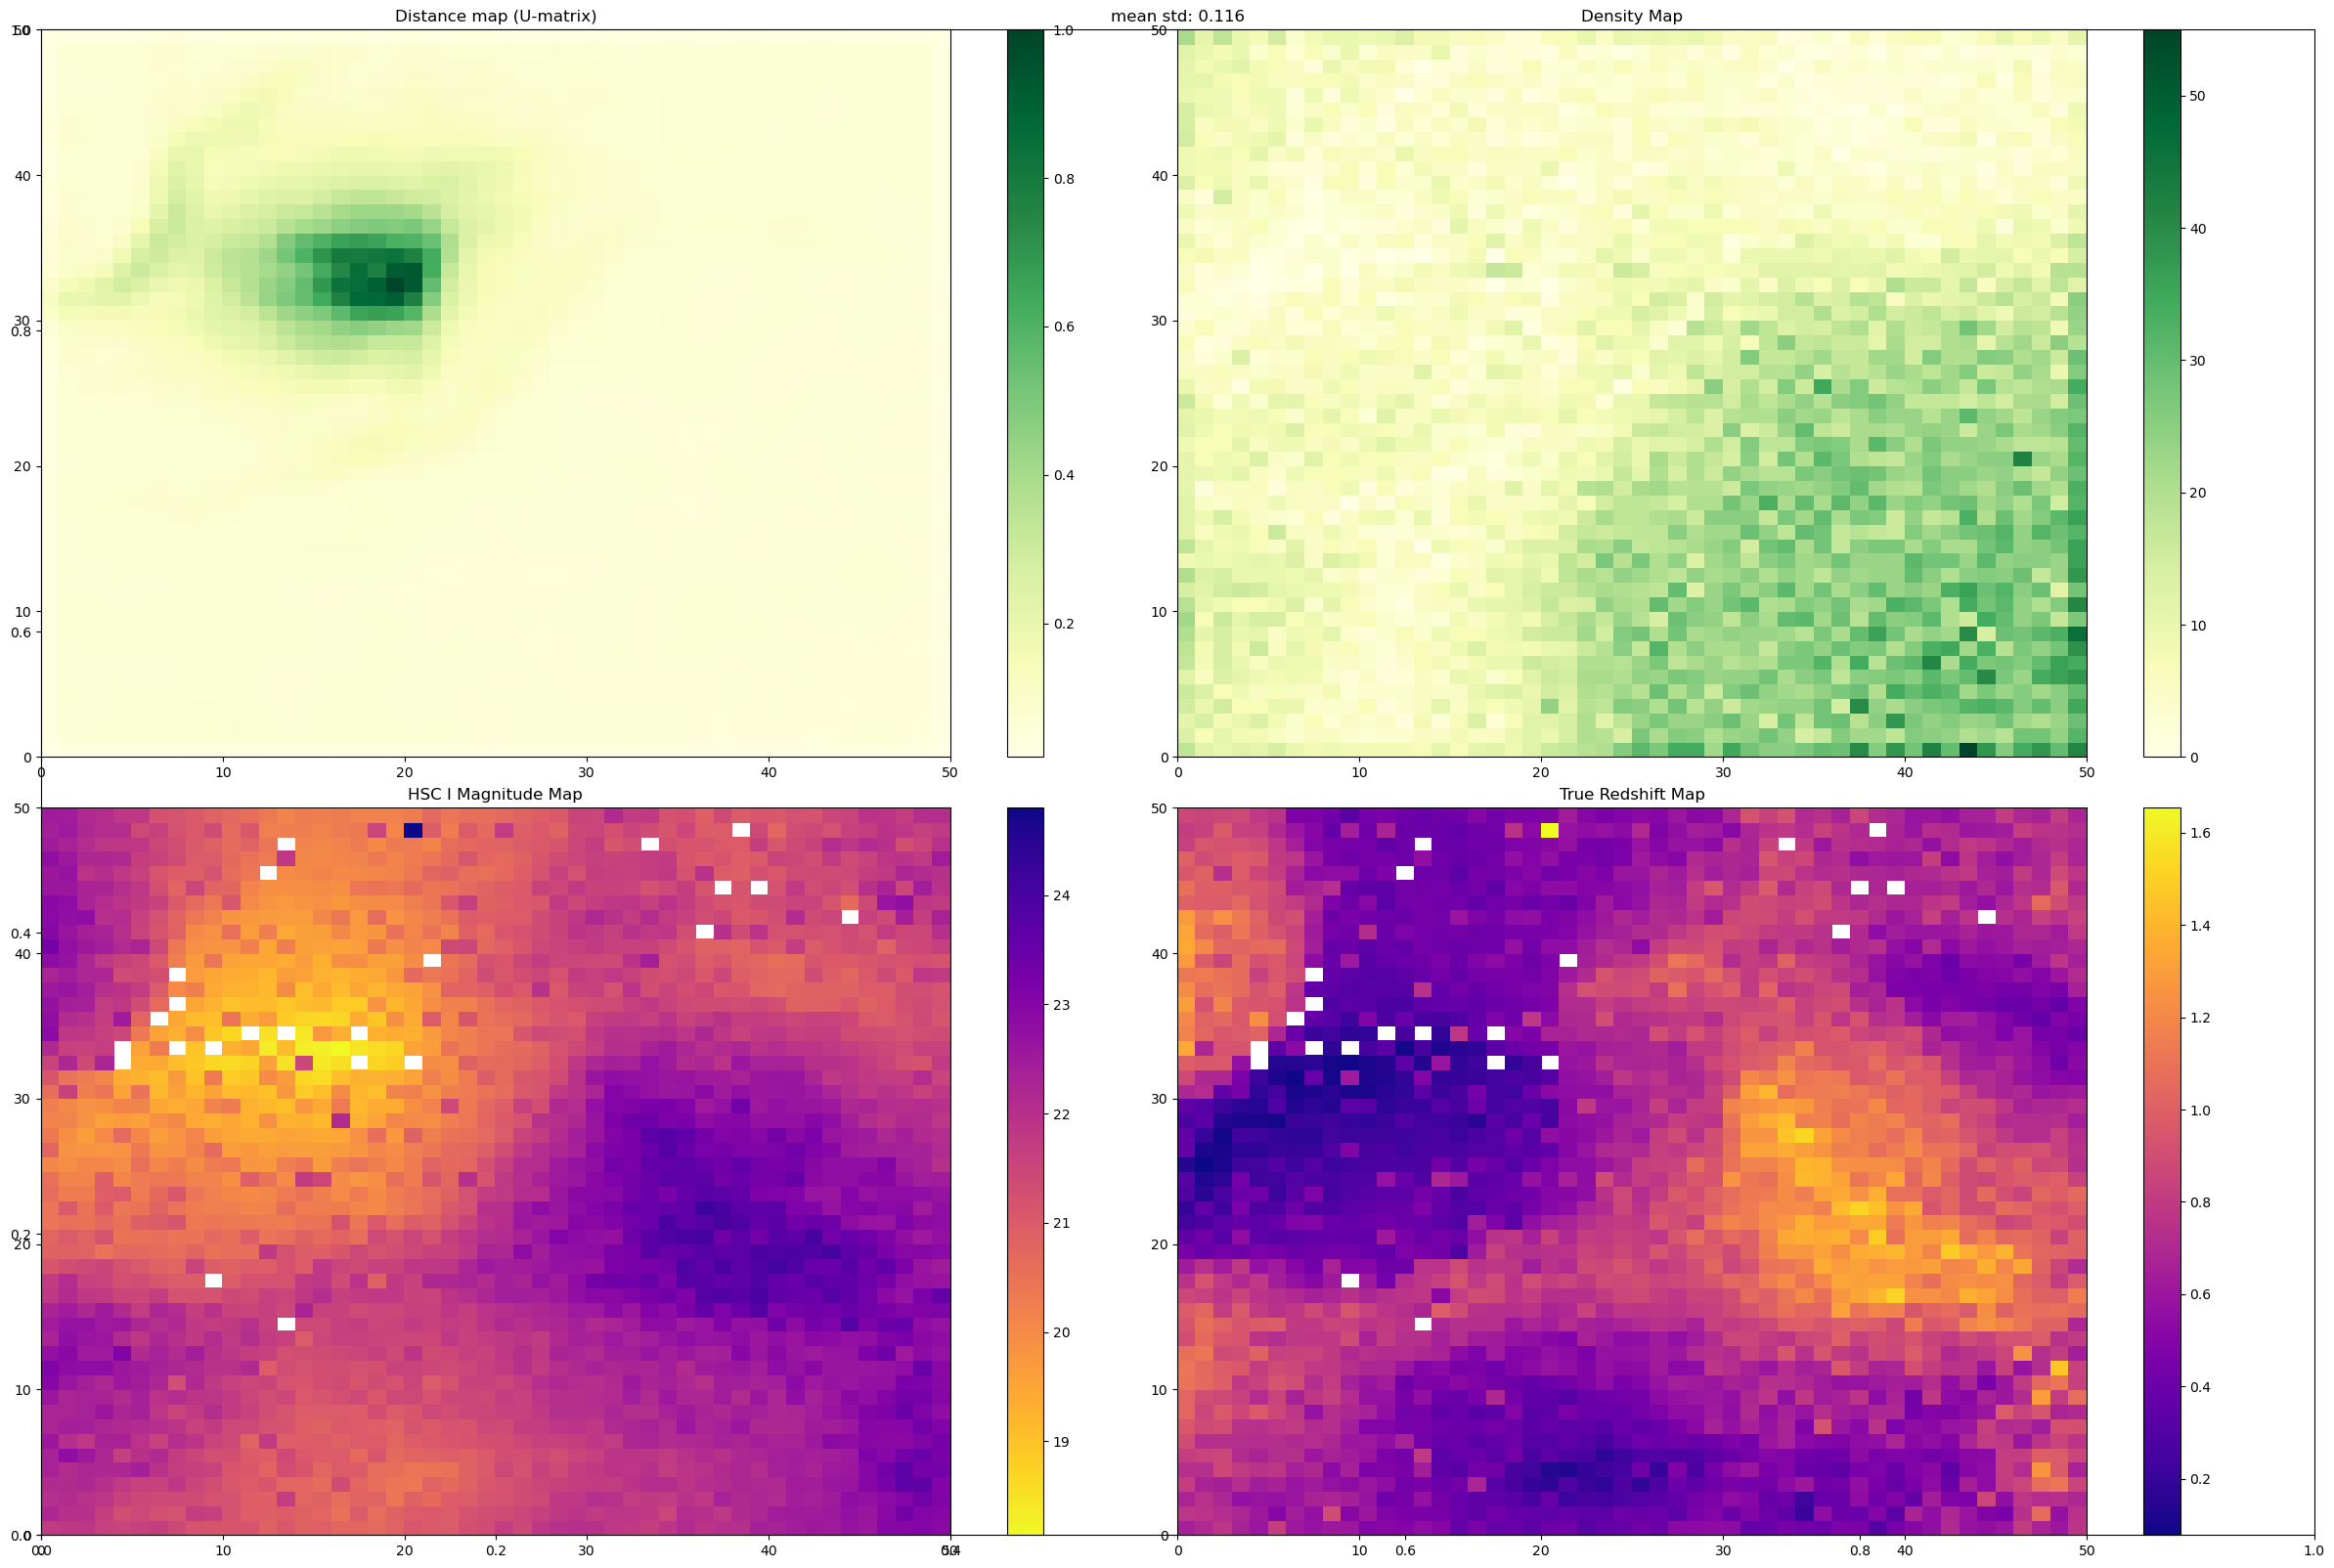

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.33180608429067143
Quantization error: 4.85846631404338
Average redshift std: 0.11622831010256397


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


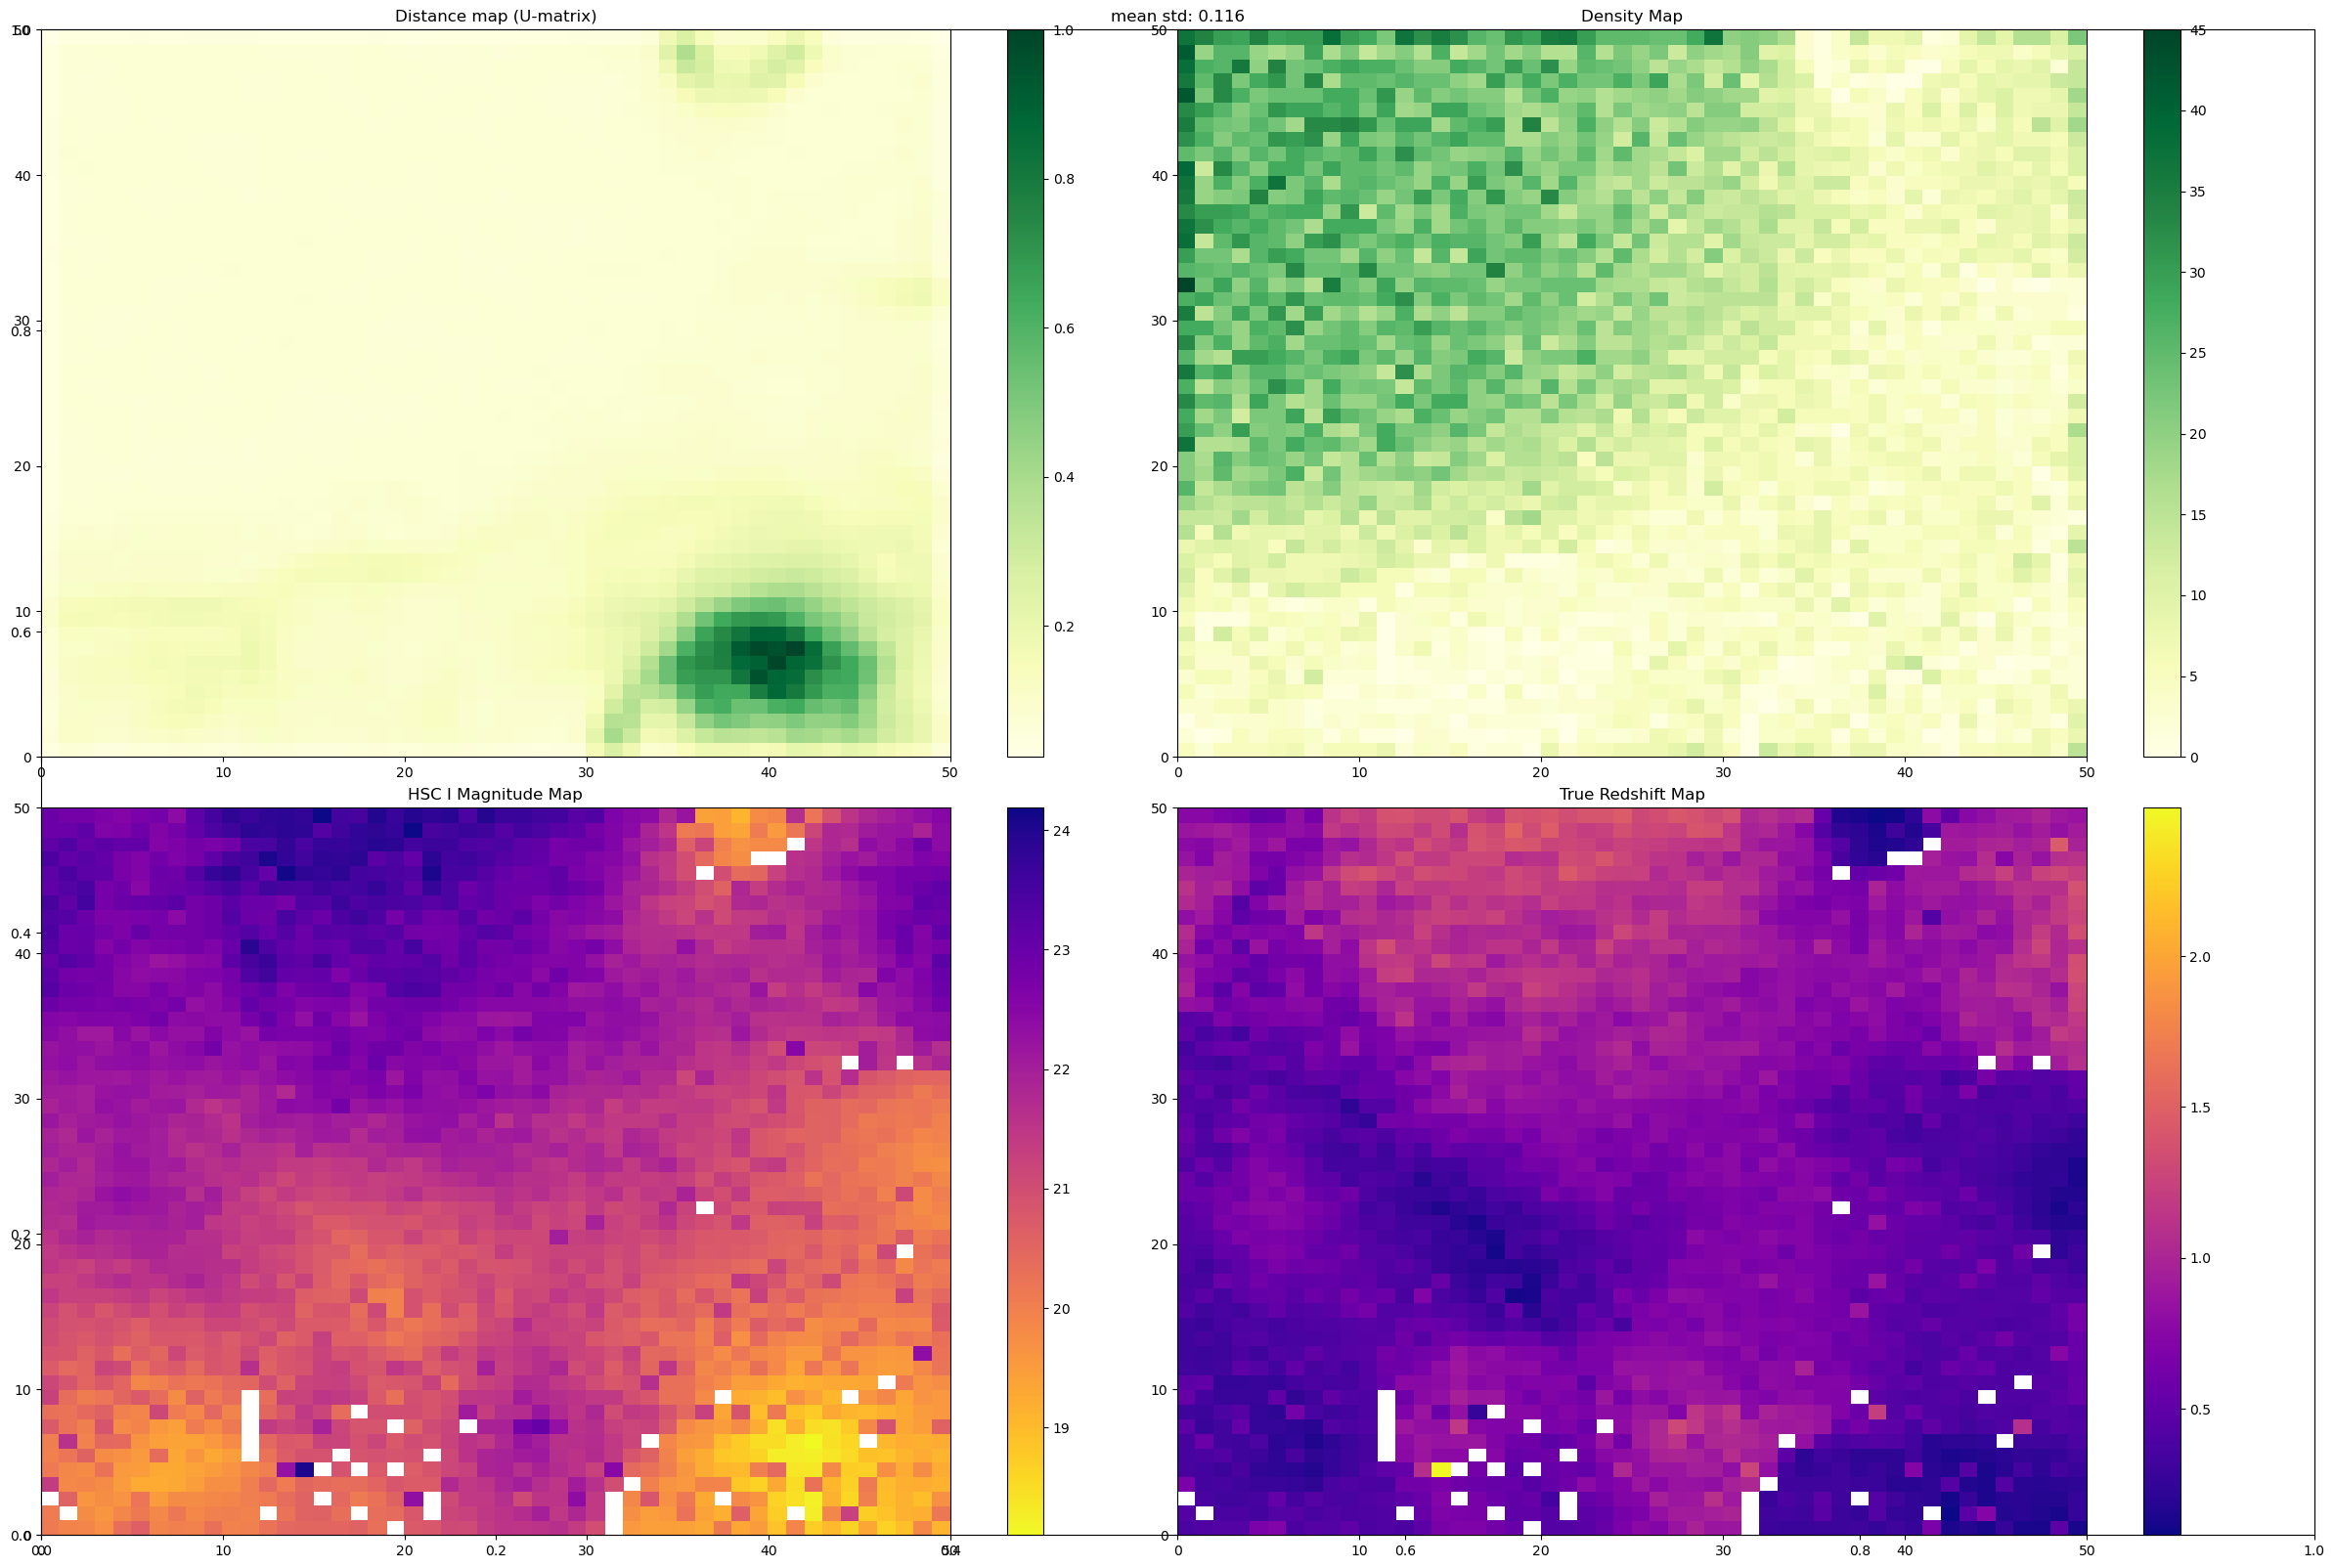

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.34241821918269716
Quantization error: 4.84097729520766
Average redshift std: 0.12449650589490044


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


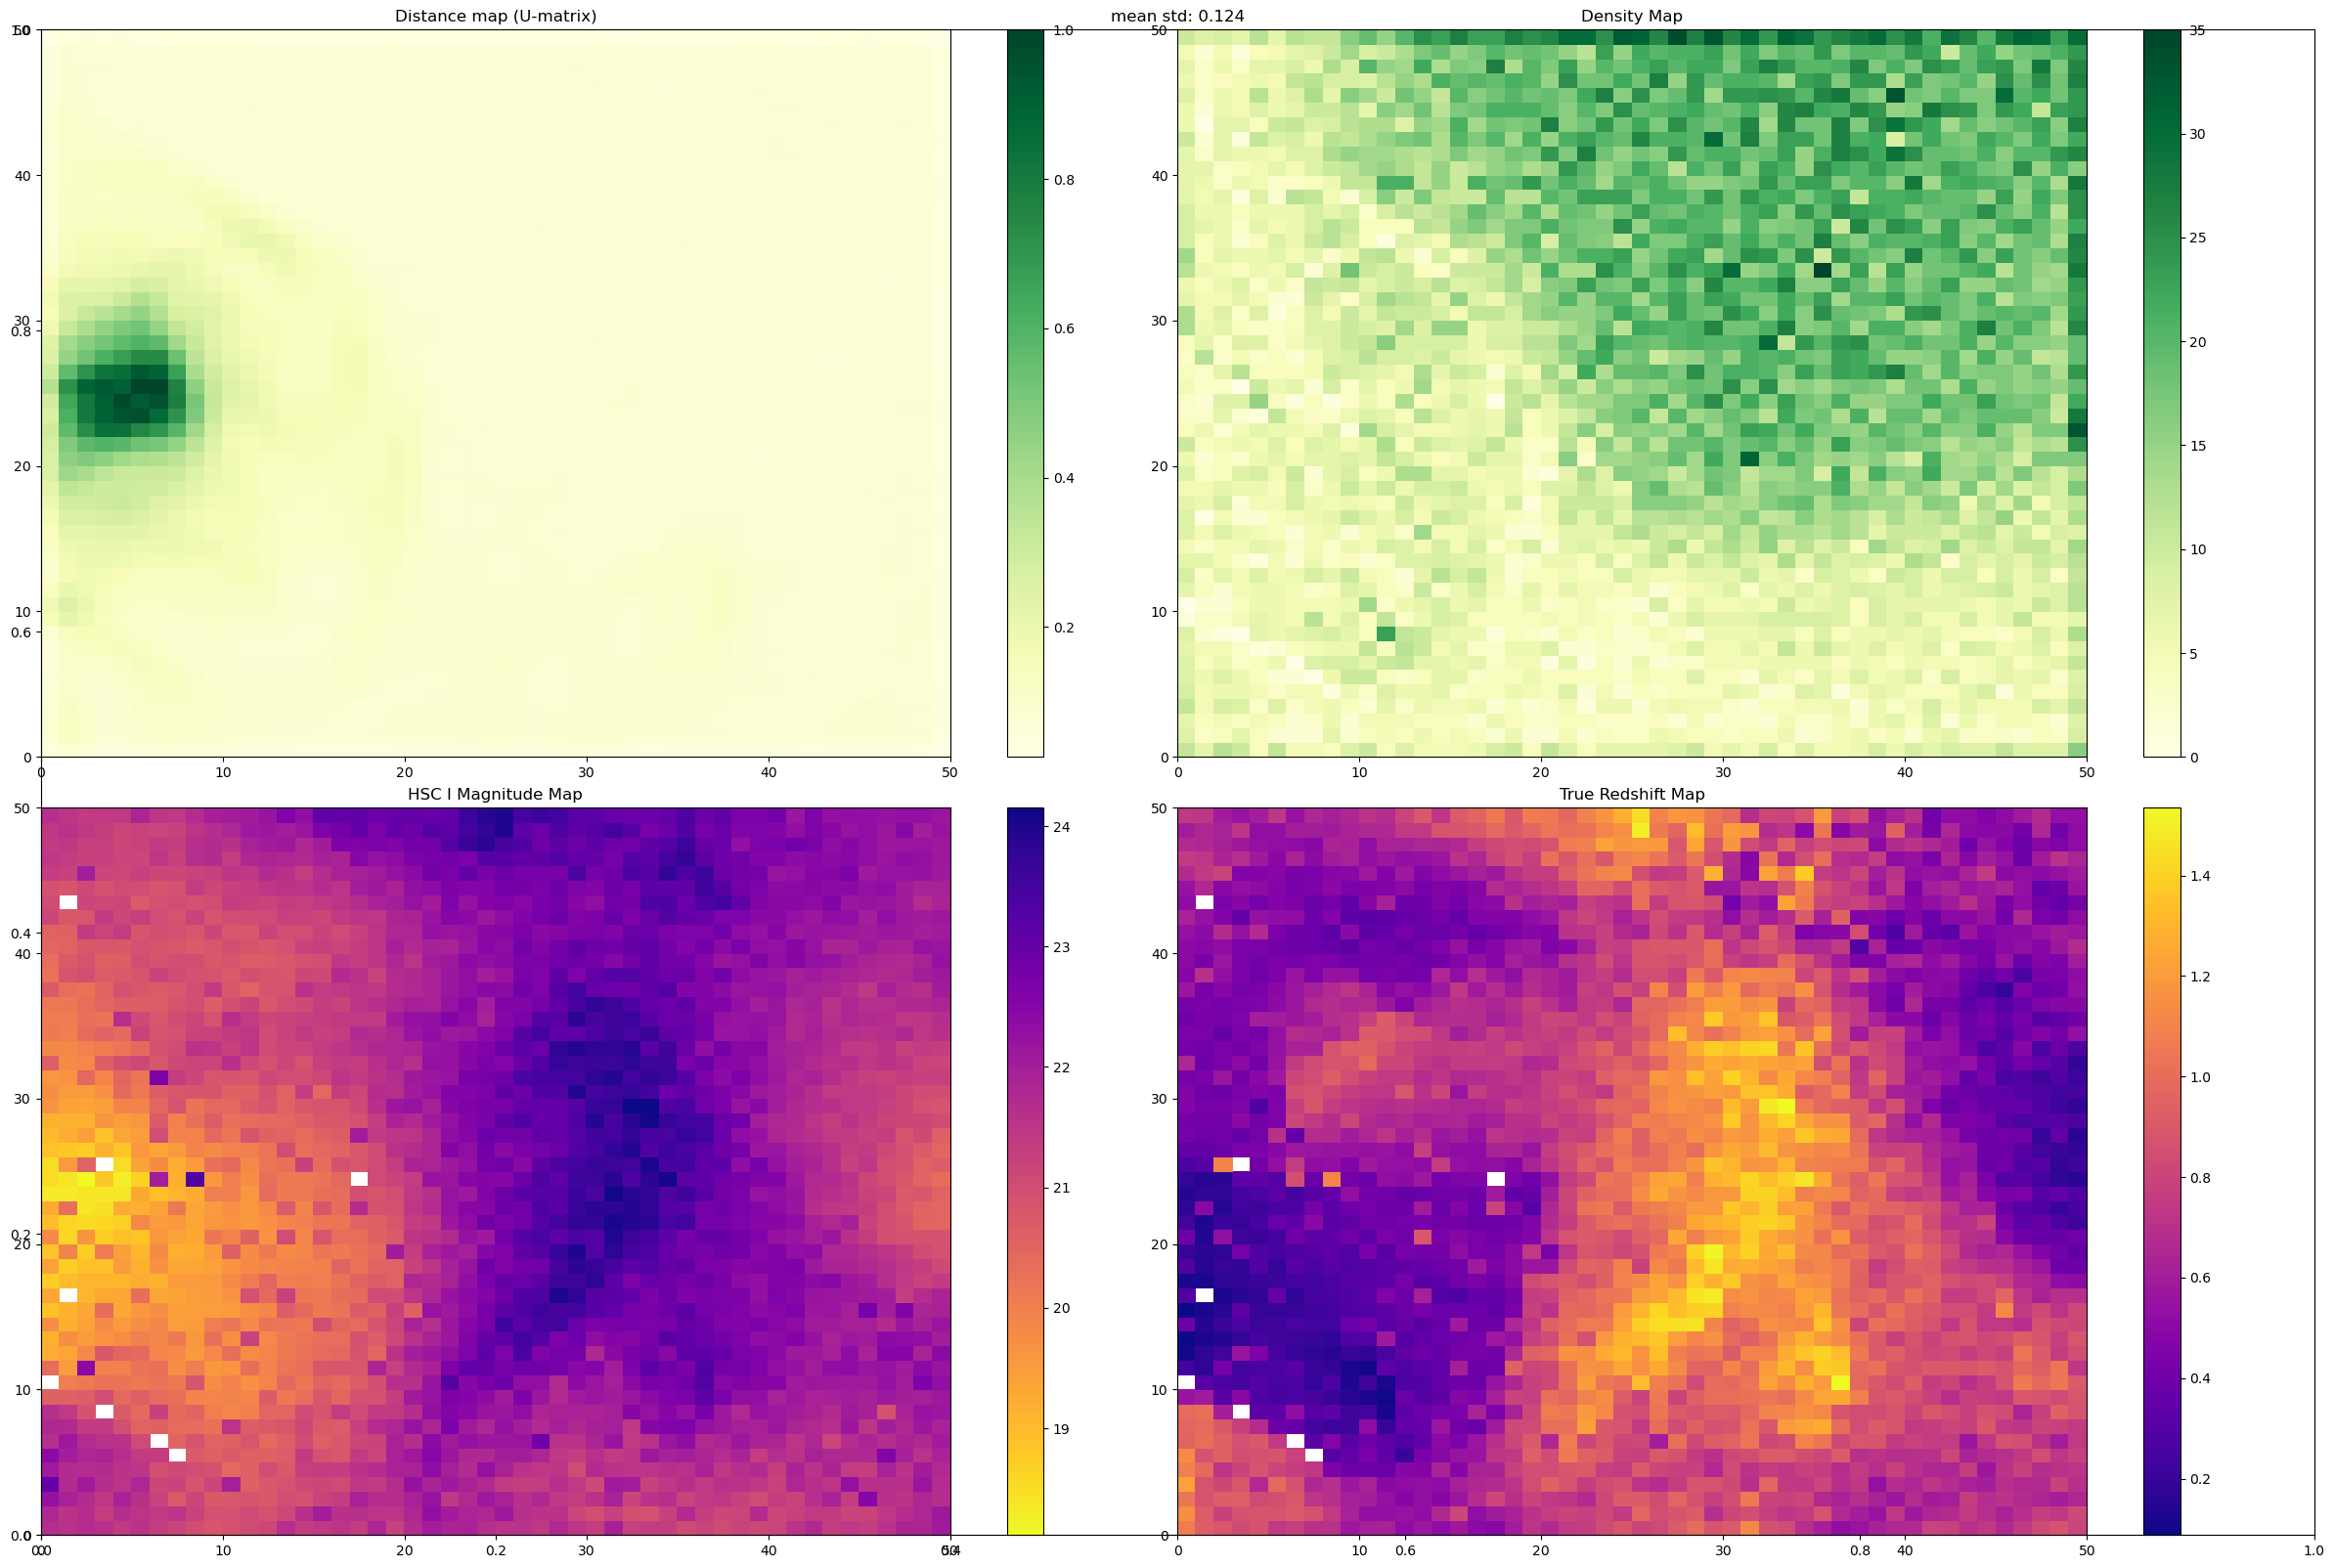

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.34322676279351816
Quantization error: 4.840780747122005
Average redshift std: 0.12534727517281055


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


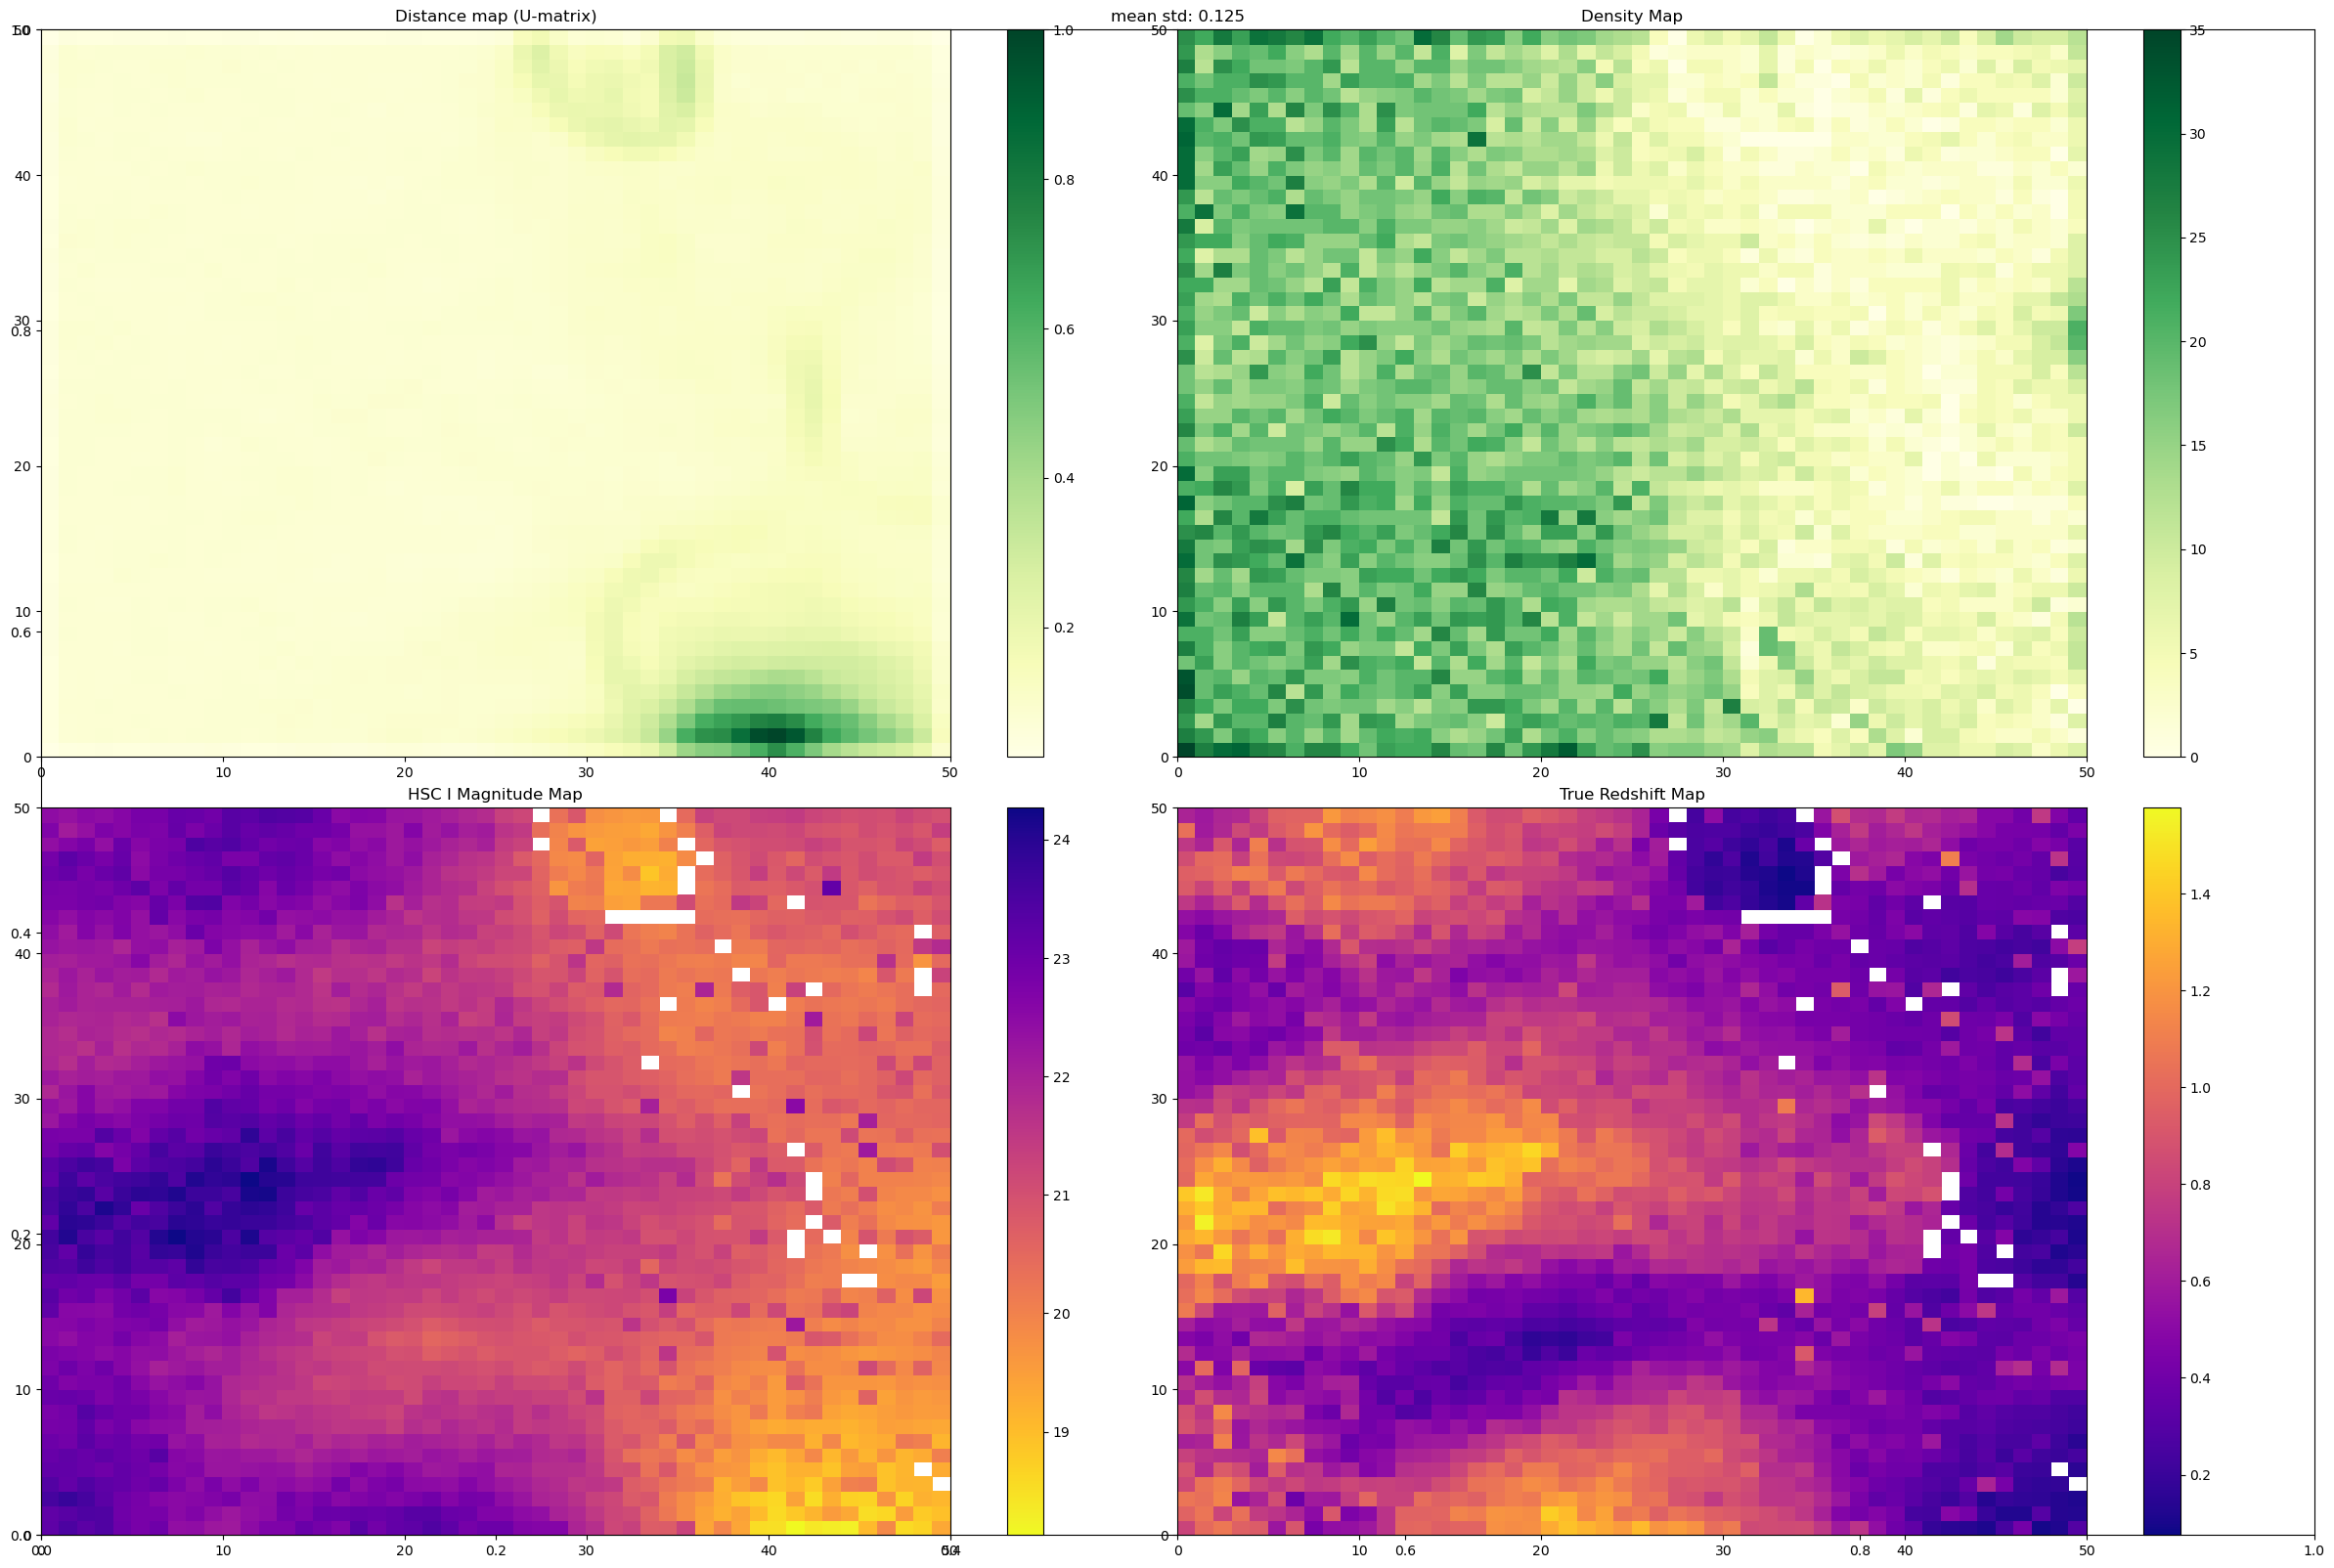

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.34790957787285653
Quantization error: 4.833868441497359
Average redshift std: 0.12961487838986235


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


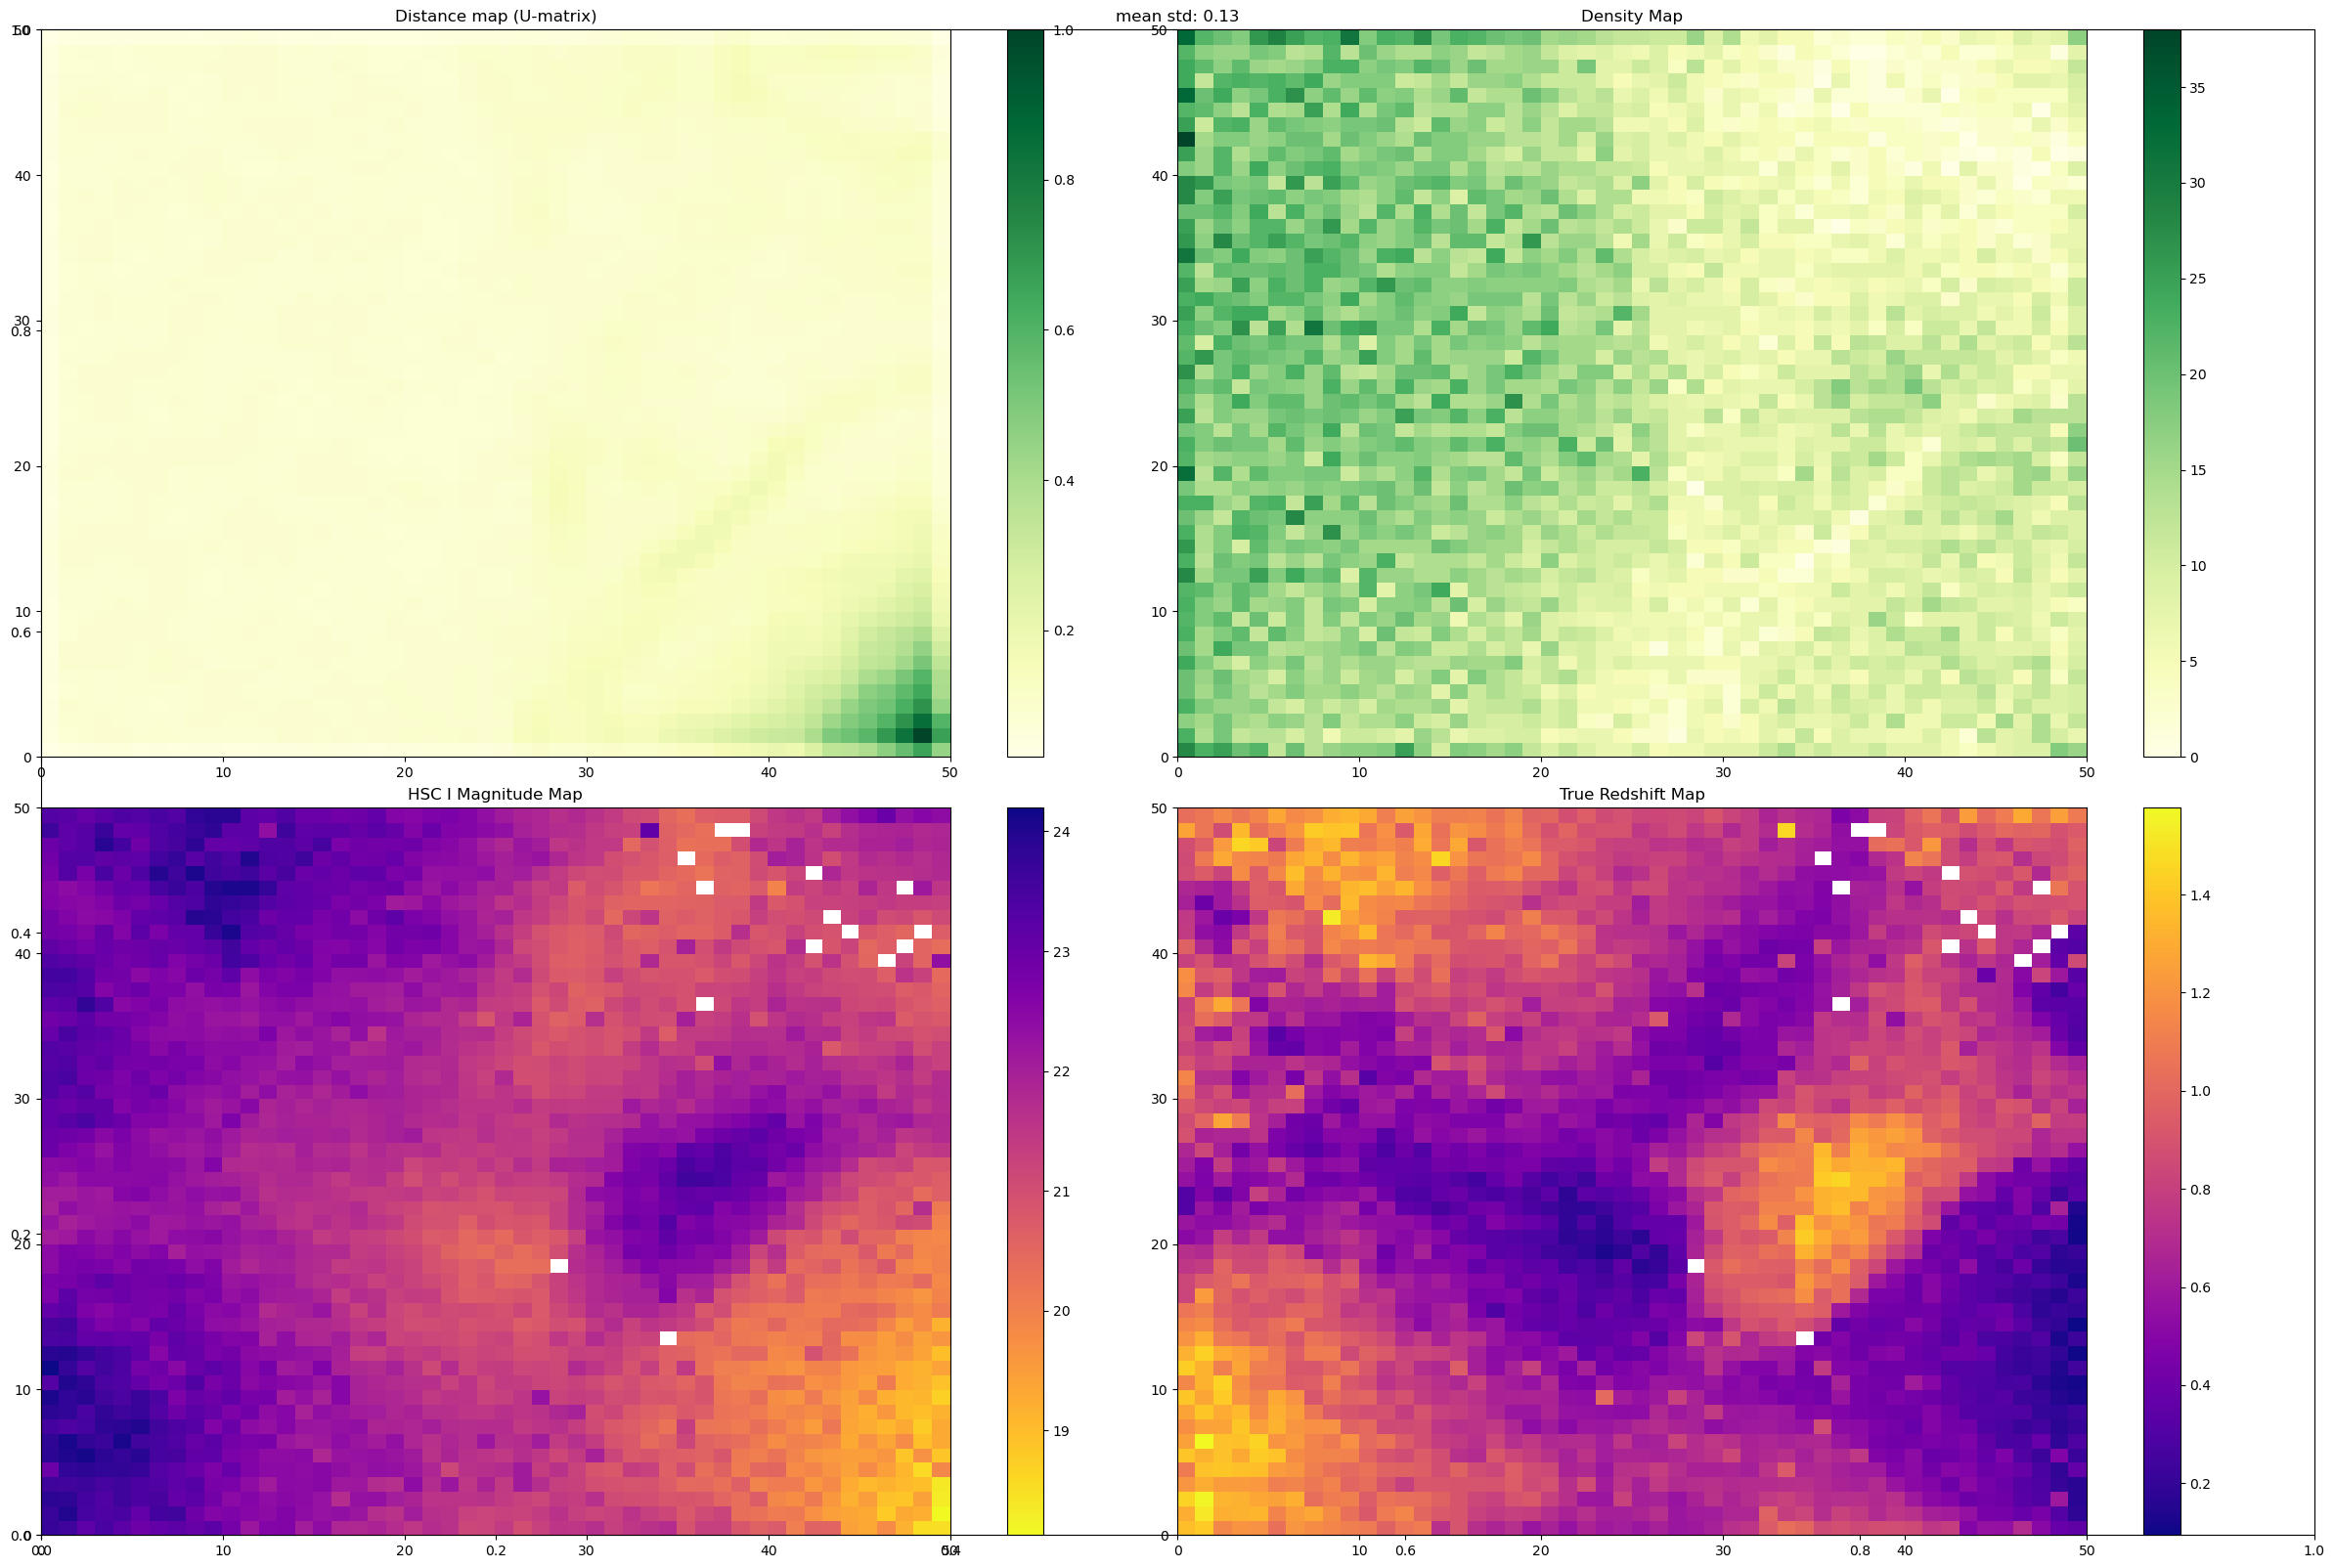

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.3596671495468787
Quantization error: 4.825143471453769
Average redshift std: 0.12356125439042576


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


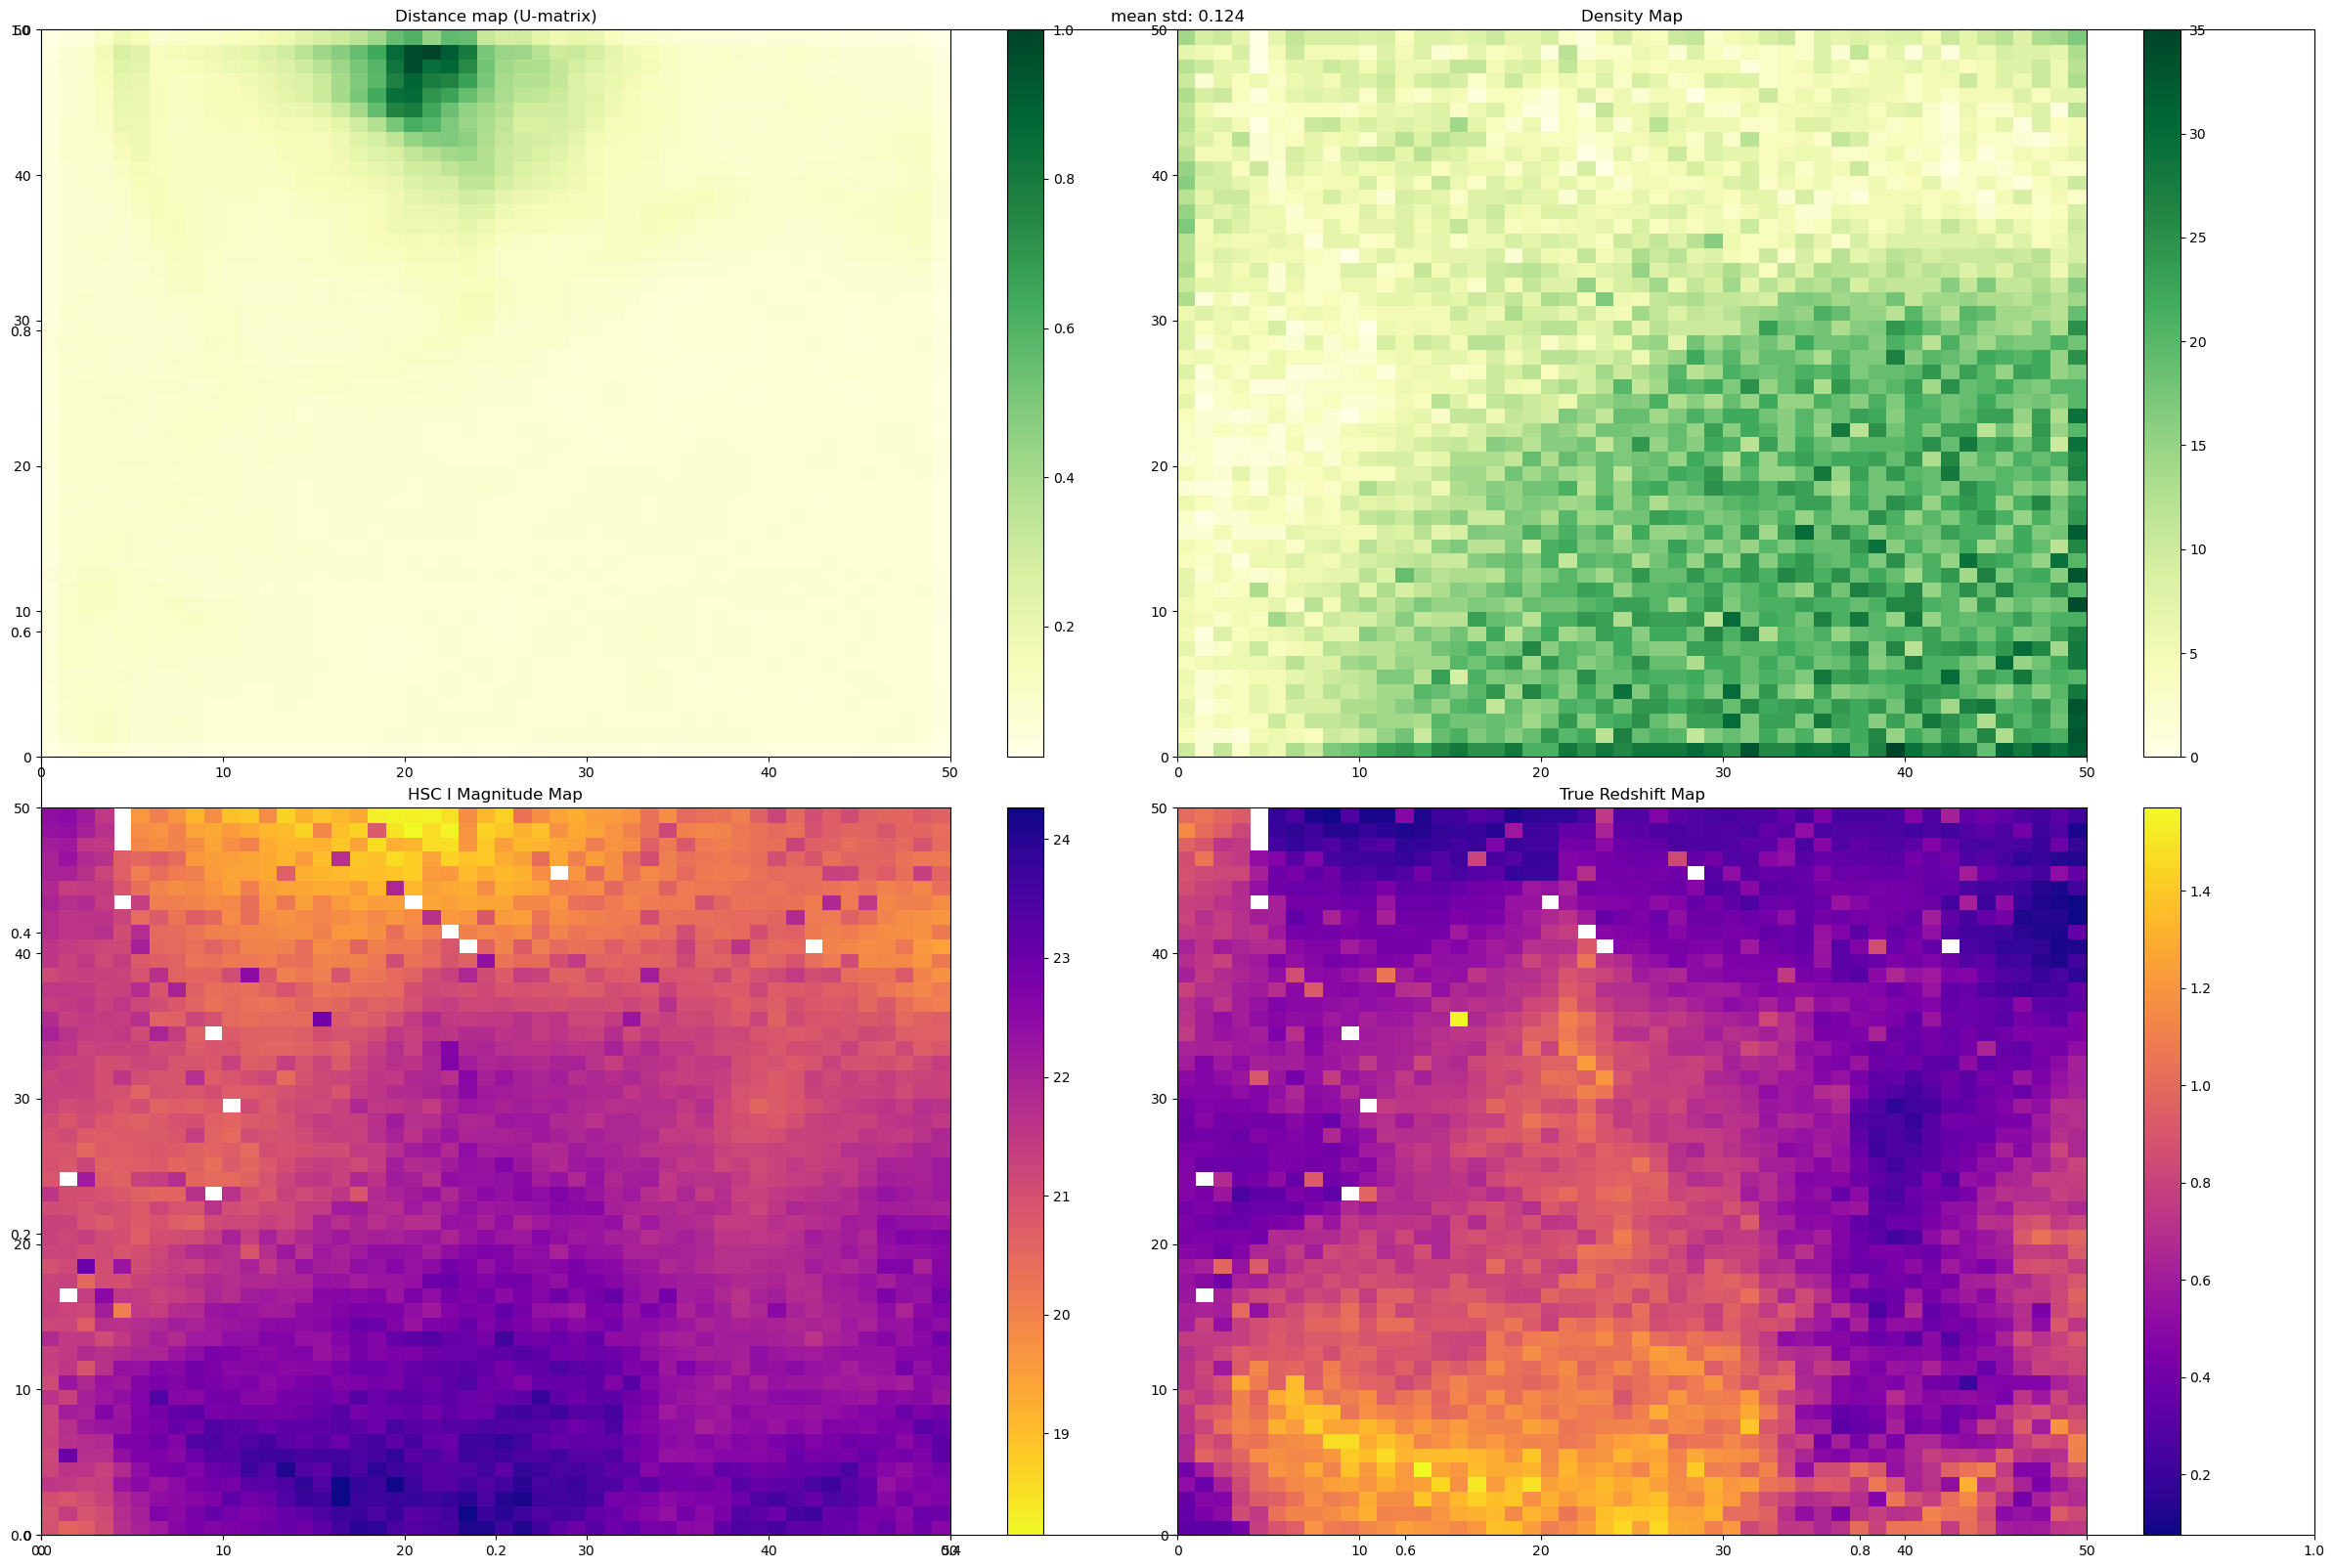

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 2, 0.1]
29683.0
Topological error: 0.36195802311087155
Quantization error: 4.820350193908412
Average redshift std: 0.13263911365077197


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26496\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


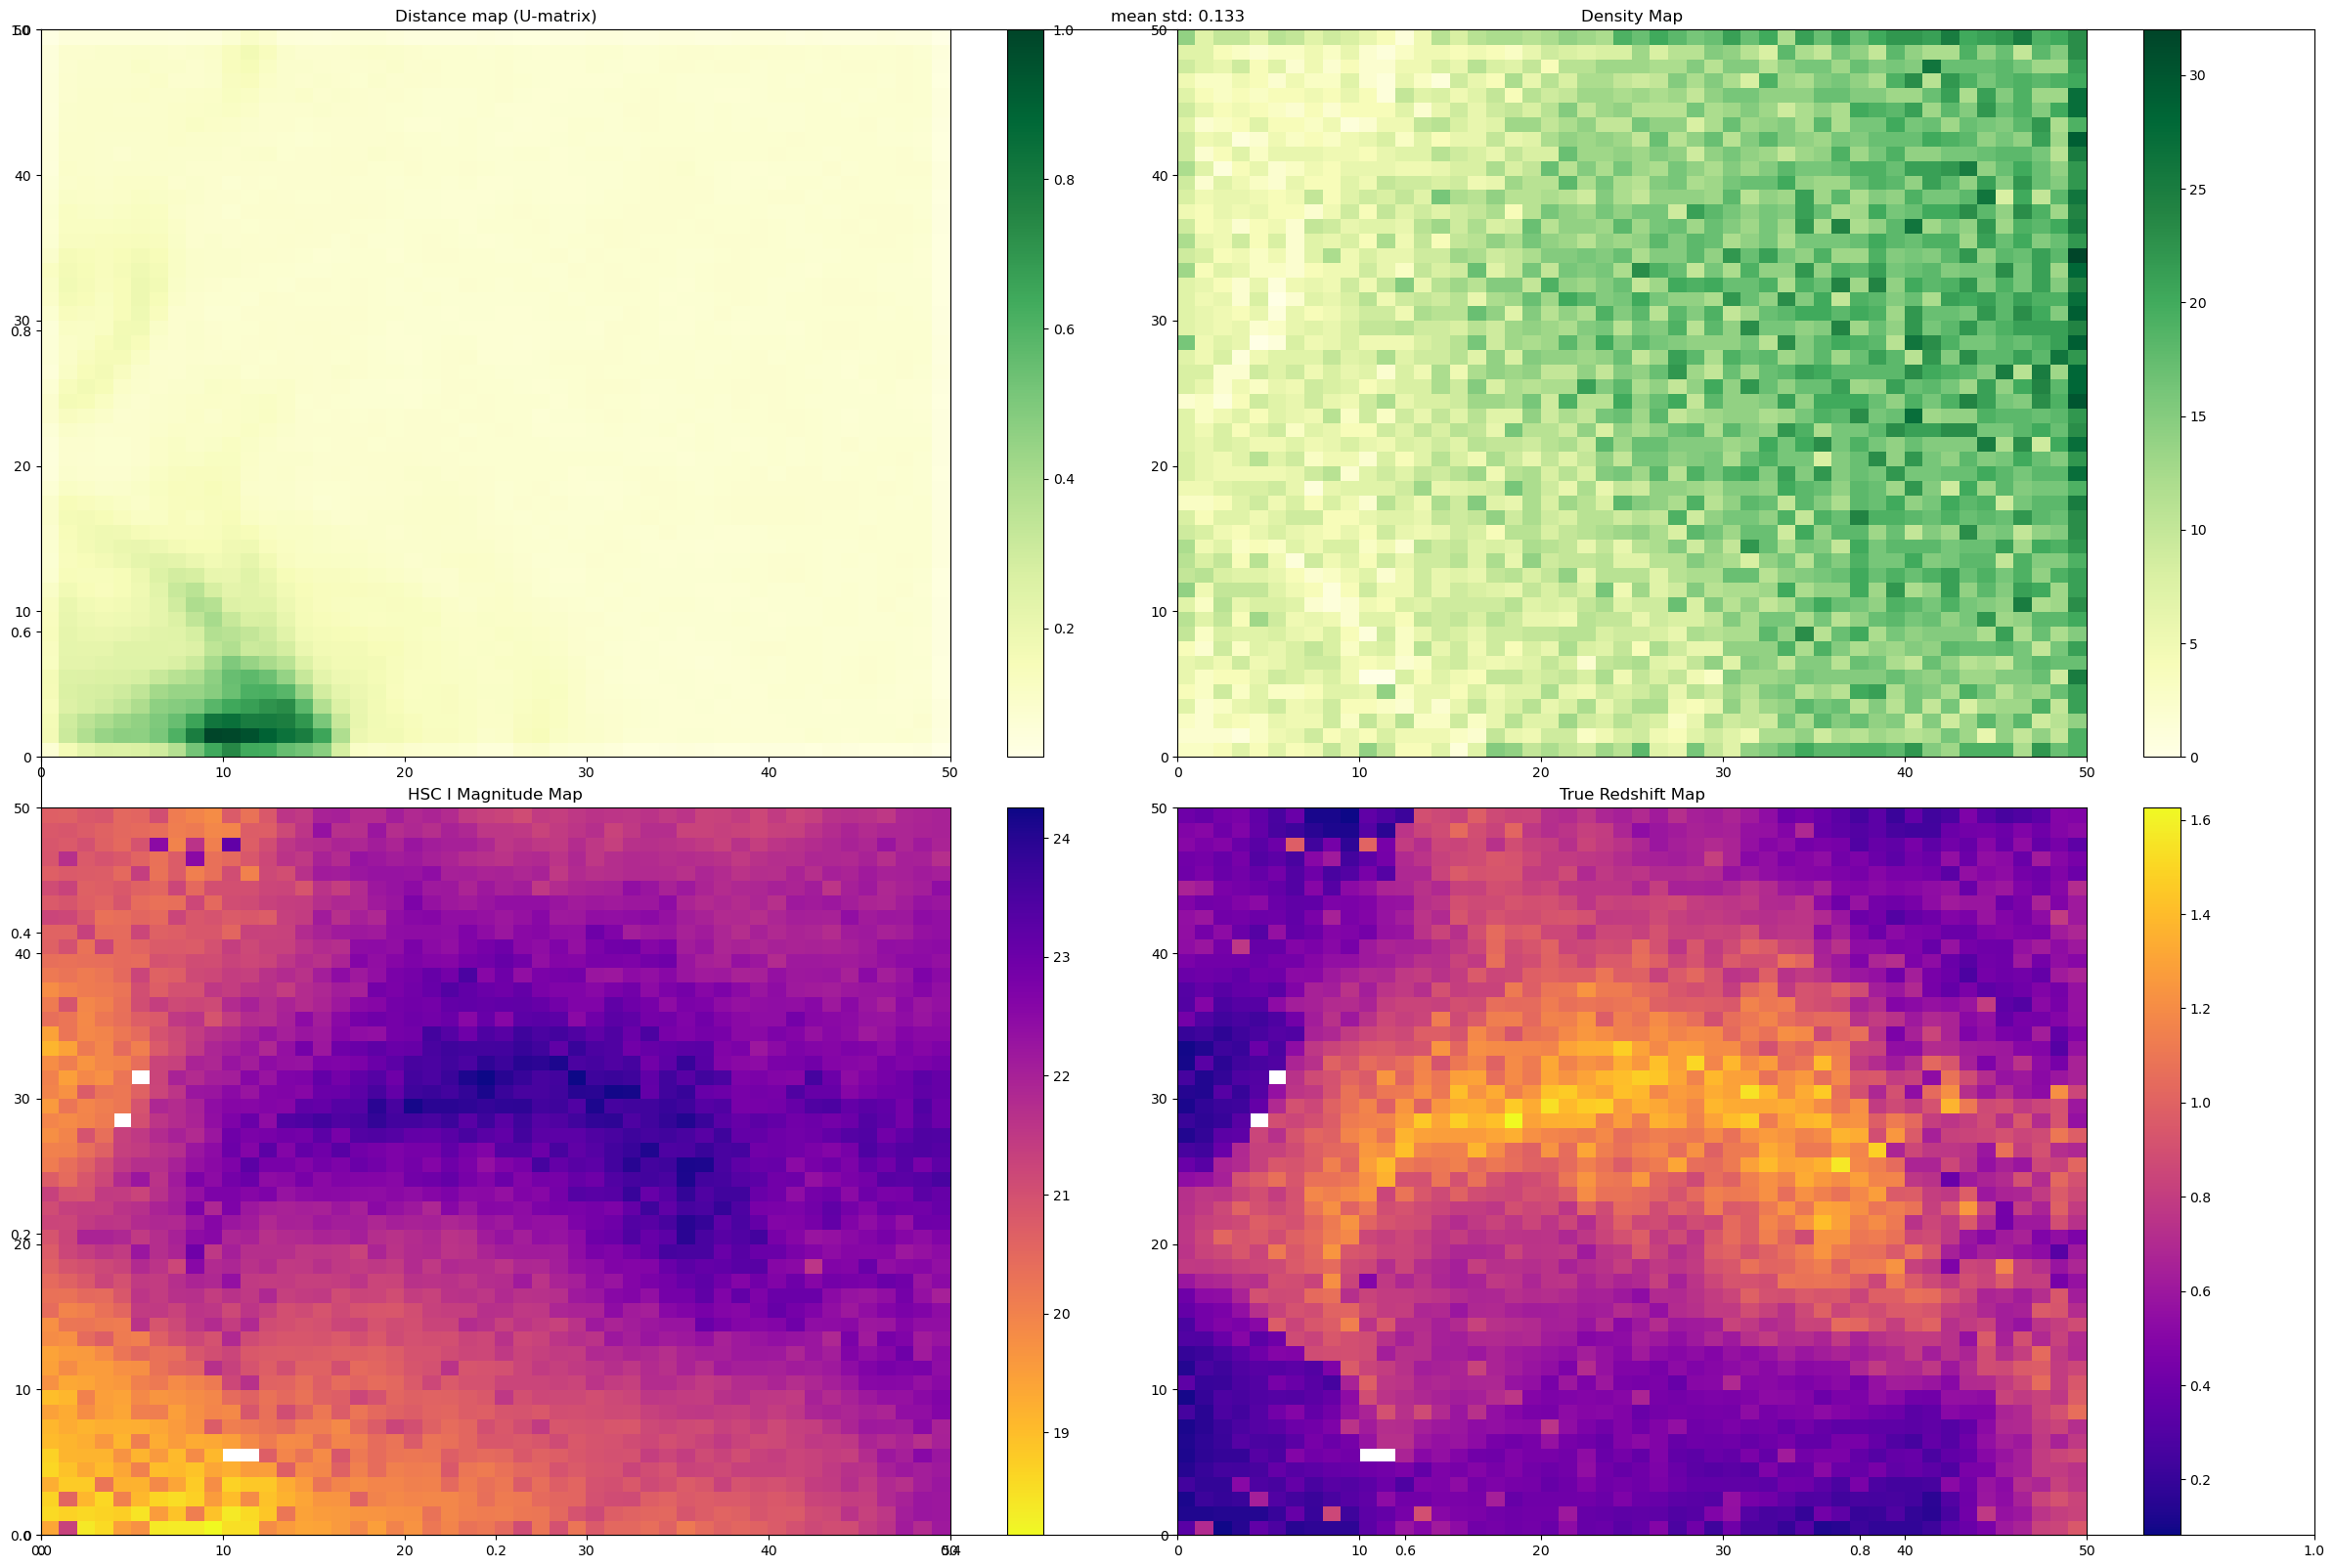

In [8]:
for i in range(1, 11):
    som = basic_som(data = data, data_type = "chi2_lup_shallow", err = err, info_data = info, dim = 50, preproc = "default", iteration = i, sigma = 2, rate = 0.1, b_scale  = 1000, save = True, distance = "chi2_distance")

In [6]:
# for i in [0.01, 0.1, 1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6]:
#     som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 50, preproc = "default", iteration = 2, sigma = 0.7, rate = 2, b_scale  = i, save = True, distance = "chi2_distance")

In [7]:
# a = os.listdir("D:/SPHEREx_SOM/record/5th_exploration/SOM/")
# c = []
# for i in a:
#     if "deep_50_0.9" in i and "1.042" in i:
#         with open("D:/SPHEREx_SOM/record/5th_exploration/SOM/" + i, "rb") as fh:
#             b = pickle.load(fh)
#             c.append(b["rate"])
# c.sort()
# c